# 구글 드라이브 마운트

In [463]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [464]:
import os
from google.colab import drive

os.chdir('/content/drive/MyDrive/베이지안자료분석PBL')
print("Updated Working Directory:", os.getcwd())

Updated Working Directory: /content/drive/.shortcut-targets-by-id/1QBz0XuviXOF73-k1i-J3boF2ZkkI3zjF/베이지안자료분석PBL


# 데이터 로드

In [465]:
import pandas as pd

weather = pd.read_csv("./data/final_data/weather_data.csv")
coin = pd.read_csv("./data/final_data/btc_data.csv")

In [466]:
print(len(weather))
print(len(coin))

2618
2618


In [467]:
coin.columns

Index(['close_pct', 'mfi', 'williams', 'date'], dtype='object')

In [468]:
display(weather.shape)
display(coin.shape)

(2618, 6)

(2618, 4)

# 데이터 전처리

## 데이터 병합

In [469]:
data = pd.merge(coin, weather, on = "date", how='outer')

In [470]:
data.head()

close_pct        mfi   williams        date  temp  humidity  cloud_cover  \
0   0.037266  54.406803  -7.404349  2017-08-30  20.4      65.1         42.6   
1   0.023285  57.451006  -1.525918  2017-08-31  22.3      60.5         29.1   
2  -0.075031  68.335974  -3.408838  2017-09-01  17.8      44.6         21.8   
3   0.008260  63.663045 -30.343882  2017-09-02  16.3      62.2         33.1   
4  -0.090699  57.060915 -27.943919  2017-09-03  17.5      87.9         82.2   

   solar_radiation  is_rain  
0            229.2        1  
1            228.8        1  
2            261.0        0  
3            185.2        1  
4             87.9        1

In [471]:
df = data.copy().drop(['is_rain'], axis=1)

## 데이터 분포 확인

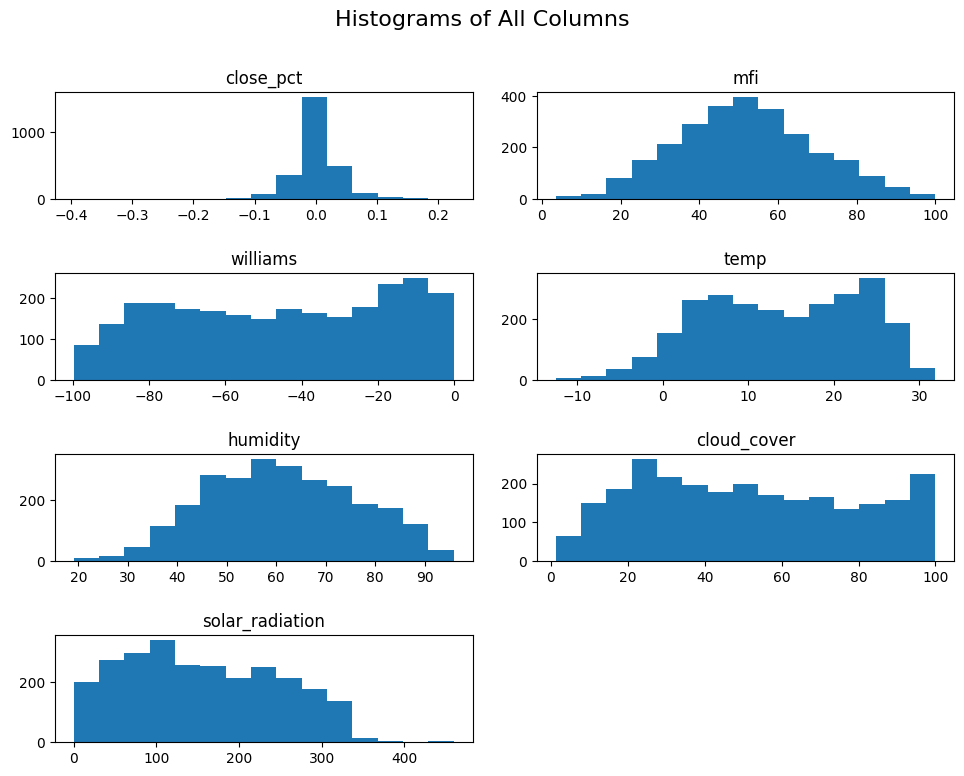

In [472]:
import matplotlib.pyplot as plt

# 히스토그램 생성
df.hist(bins=15, figsize=(10, 8), layout=(4, 2), grid=False)
plt.suptitle("Histograms of All Columns", fontsize=16)  # 공통 제목
plt.tight_layout(pad=2.0)
plt.show()

<Axes: >

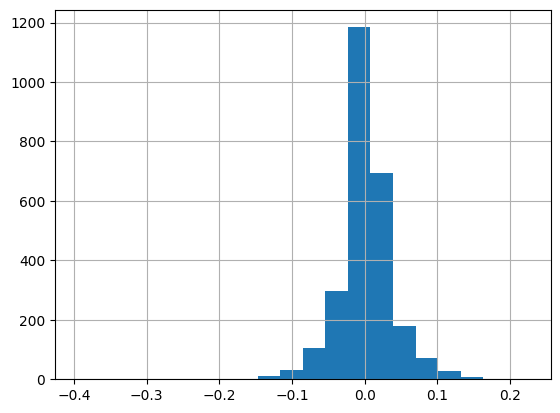

In [473]:
df['close_pct'].hist(bins=20)

## 데이터 상관관계 분석

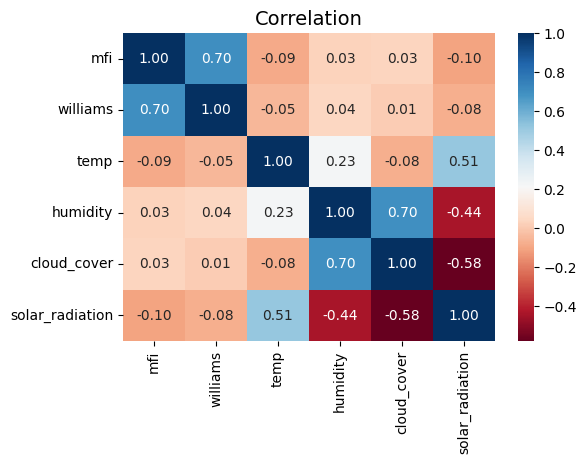

In [474]:
import seaborn as sns

# 상관 행렬 계산
cor_matrix = df.drop(['date', 'close_pct'], axis=1).corr()

# 히트맵 생성
plt.figure(figsize=(6, 4))  # 크기 조정
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap="RdBu", cbar=True)
plt.title("Correlation", fontsize=14)
plt.show()

## PCA 수행

In [475]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

numeric_data = df.drop(['date', 'close_pct'], axis=1)

# 데이터 표준화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(numeric_data)

# PCA 수행
pca = PCA()
pca_result = pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(len(pca.components_))])

# PCA 분산 설명도
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.37019961, 0.28189878, 0.21797068, 0.05032168, 0.04684847,
       0.03276078])

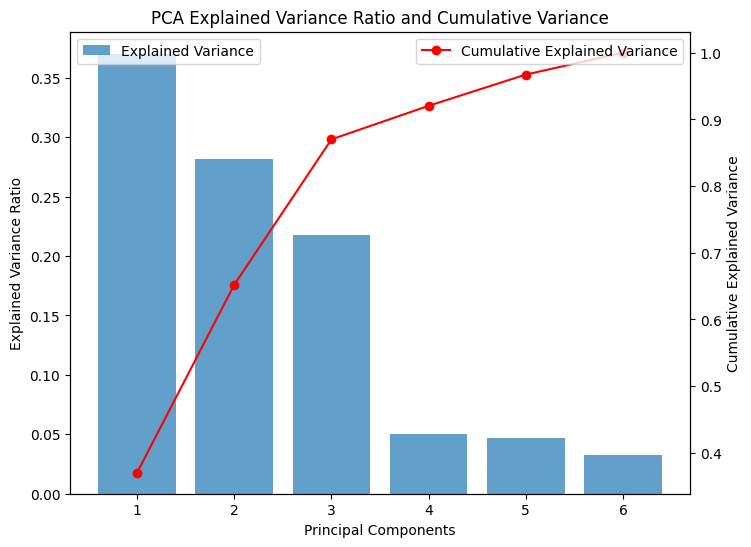

In [476]:
import numpy as np

fig, ax1 = plt.subplots(figsize=(8, 6))

# 설명 분산 확인을 위한 막대 그래프
ax1.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Explained Variance')
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_xticks(range(1, len(explained_variance) + 1))
ax1.legend(loc='upper left')

# 설명 분산 확인을 위한 선 그래프
ax2 = ax1.twinx()
ax2.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', color='red', label='Cumulative Explained Variance')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.legend(loc='upper right')

plt.title('PCA Explained Variance Ratio and Cumulative Variance')
plt.show()

In [477]:
# PCA loading 확인
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=numeric_data.columns
)
loadings

PC1       PC2       PC3       PC4       PC5       PC6
mfi              0.191069  0.660974  0.152426  0.624334 -0.336321  0.021603
williams         0.175069  0.658840  0.197081 -0.598645  0.370440 -0.028954
temp            -0.200652 -0.149814  0.785409 -0.048151 -0.176263 -0.535761
humidity         0.499996 -0.236661  0.426398 -0.190541 -0.301669  0.620379
cloud_cover      0.571245 -0.219308  0.134097  0.381126  0.648725 -0.203715
solar_radiation -0.562374  0.049944  0.348224  0.260672  0.454692  0.534121

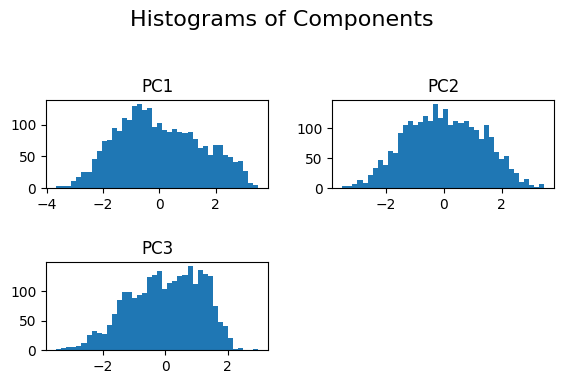

In [478]:
pca_df[['PC1', 'PC2', 'PC3']].hist(bins=40, figsize=(6, 4), layout=(2, 2), grid=False)
plt.suptitle("Histograms of Components", fontsize=16)  # 공통 제목
plt.tight_layout(pad=2.0)
plt.show()

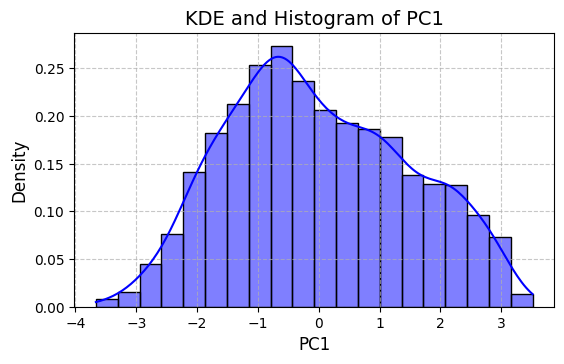

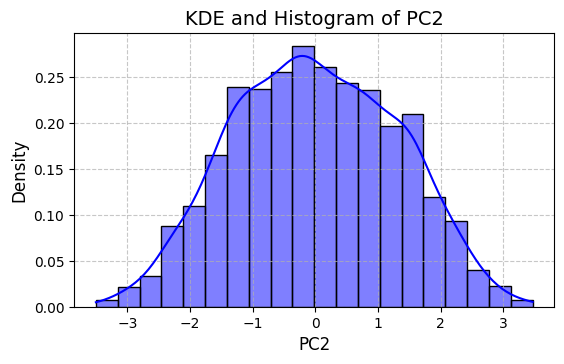

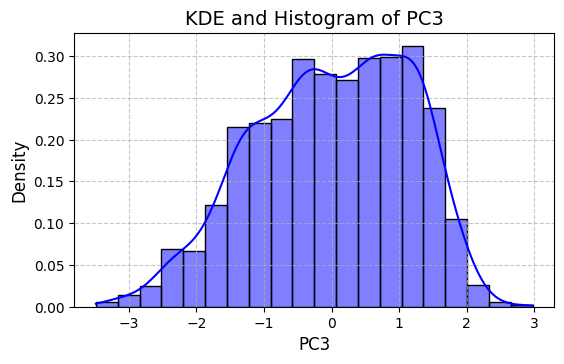

In [479]:
# PCA 컴포넌트 히스토그램 생성
components = ['PC1', 'PC2', 'PC3']

for i, component in enumerate(components, 1):
    plt.figure(figsize=(6, 4))
    sns.histplot(pca_df[component], bins=20, kde=True, color='blue', edgecolor='black', stat="density")
    plt.xlabel(component, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(f"KDE and Histogram of {component}", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)  # 격자 추가
    plt.tight_layout(pad=2.0)
    plt.show()

In [480]:
pca_df = pca_df[["PC1", "PC2", "PC3"]]

In [481]:
pca_df.set_index(data["date"], inplace = True)

## 날짜, close_pct 열과 merge

In [482]:
pca_df = pd.merge(pca_df, data[["date", "close_pct"]], left_on = pca_df.index, right_on = 'date', how = 'left')

In [483]:
pca_df["close_pct"] *= 100

In [484]:
final_data = pca_df.copy()
final_data.head(3)

PC1       PC2       PC3        date  close_pct
0 -0.379293  0.917002  1.180754  2017-08-30   3.726559
1 -0.781118  1.315675  1.213716  2017-08-31   2.328520
2 -1.450274  2.082058  0.547664  2017-09-01  -7.503139

## 변동률 10% 초과 데이터 삭제

In [485]:
tmp = final_data[final_data["close_pct"] > 10]
tmp2 = final_data[final_data["close_pct"] < -10]
final_data.drop(tmp.index, inplace = True)
final_data.drop(tmp2.index, inplace = True)

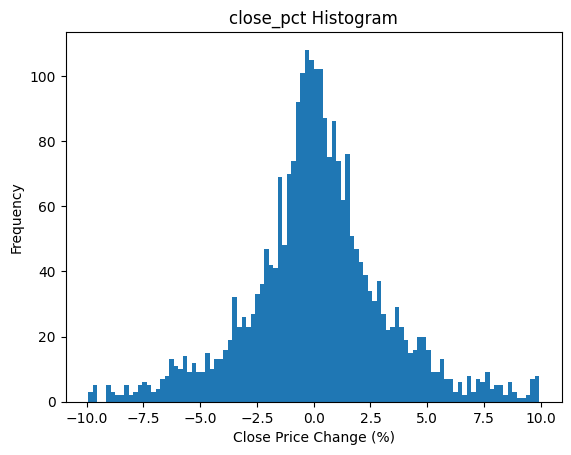

In [486]:
plt.hist(final_data["close_pct"], bins=100)
plt.title('close_pct Histogram')
plt.xlabel('Close Price Change (%)')
plt.ylabel('Frequency')
plt.show()

## 데이터 분할

In [487]:
from sklearn.model_selection import train_test_split

def_data, update_data = train_test_split(final_data, test_size=0.7, shuffle=False)
update_data, pred_data = train_test_split(update_data, test_size=0.5, shuffle=False)

# 사전확률분포 정의

In [488]:
np.random.seed(27)

In [489]:
# 데이터의 95%를 포함하는 구간
print(def_data["close_pct"].quantile(0.025))
print(def_data["close_pct"].quantile(0.975))

-7.498114772441059
7.408847757190987


In [490]:
# 변동률 구간 20개로 split

theta_bins = 20
close_pct_range = np.linspace(-10, 10, theta_bins + 1)

prior_probabilities = np.full(theta_bins, 1 / theta_bins)

theta_intervals = pd.IntervalIndex.from_breaks(close_pct_range, closed='right')
def_data['theta_interval'] = pd.cut(def_data['close_pct'], bins=theta_intervals)

theta_prior = pd.DataFrame({
    'theta_interval': theta_intervals,
    'prior_probability': prior_probabilities
})

In [491]:
# 경험적 사전분포를 위한 준비

close_pct_mean = def_data['close_pct'].mean()
close_pct_std = def_data['close_pct'].std()

print(close_pct_mean, close_pct_std)

0.060414820334349764 3.3725069989726735


In [492]:
from scipy.stats import norm

prior_distribution = norm(loc=close_pct_mean, scale=close_pct_std)

num_bins = 20
close_pct_range = np.linspace(-10, 10, theta_bins + 1)
theta_intervals = pd.IntervalIndex.from_breaks(close_pct_range, closed='right')

theta_midpoints = np.array([interval.mid for interval in theta_intervals])

# 구간 중앙에서의 사전확률 계산
prior_probabilities = prior_distribution.pdf(theta_midpoints)
prior_probabilities /= prior_probabilities.sum()  # 정규화

prior_df = pd.DataFrame({
    'theta_interval': [str(interval) for interval in theta_intervals],
    'prior_probability': prior_probabilities
})
prior_df.head(3)

theta_interval  prior_probability
0  (-10.0, -9.0]           0.002134
1   (-9.0, -8.0]           0.004733
2   (-8.0, -7.0]           0.009615

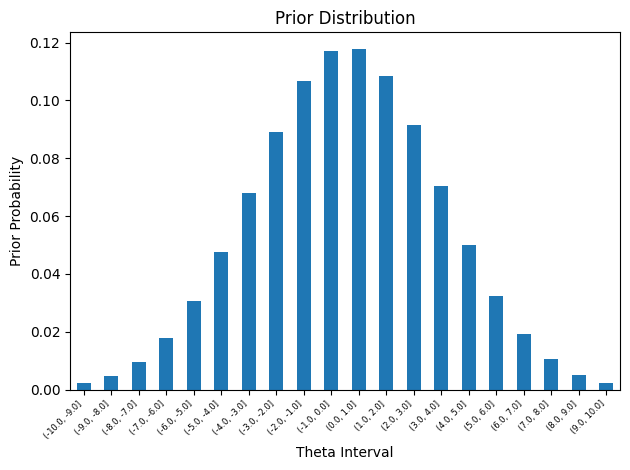

In [493]:
# theta_interval을 범주형으로 명시하고 모든 값 포함
prior_df['theta_interval'] = prior_df['theta_interval'].astype(str)  # theta_interval을 문자열로 변환

# 그래프 생성
prior_df.plot(
    title="Prior Distribution",
    x='theta_interval',
    y='prior_probability',
    kind='bar',  # 막대그래프로 표현
    legend=False  # 범례 제거
)

# x축 설정: 모든 구간이 표시되고 잘리지 않도록 조정
plt.xticks(
    rotation=45,  # 레이블 회전
    ha='right',   # 레이블 정렬
    fontsize=6    # 글자 크기
)
plt.xlabel("Theta Interval")
plt.ylabel("Prior Probability")

# 레이아웃 조정
plt.tight_layout()  # 그래프 레이아웃 자동 조정
plt.show()

# 경제 데이터 + 날씨 데이터

## 가능도 함수 생성

In [494]:
from scipy.stats import gaussian_kde

data_for_kde = def_data[['PC1', 'PC2', 'PC3']]

# 커널 밀도 추정 : PC1, PC2, PC3의 결합밀도함수 생성
kde = gaussian_kde(data_for_kde.T)

In [495]:
theta_intervals

IntervalIndex([(-10.0, -9.0],  (-9.0, -8.0],  (-8.0, -7.0],  (-7.0, -6.0],
                (-6.0, -5.0],  (-5.0, -4.0],  (-4.0, -3.0],  (-3.0, -2.0],
                (-2.0, -1.0],   (-1.0, 0.0],    (0.0, 1.0],    (1.0, 2.0],
                  (2.0, 3.0],    (3.0, 4.0],    (4.0, 5.0],    (5.0, 6.0],
                  (6.0, 7.0],    (7.0, 8.0],    (8.0, 9.0],   (9.0, 10.0]],
              dtype='interval[float64, right]')

In [496]:
# 변동률 구간별 가능도 함수 딕셔너리
kde_dict = {}

for interval in theta_intervals:
    subset = def_data[(def_data['close_pct'] > interval.left) & (def_data['close_pct'] <= interval.right)][['PC1', 'PC2', 'PC3']].dropna()

    print(subset.shape)

    kde = gaussian_kde(subset.T)
    kde_dict[str(interval)] = kde

(6, 3)
(8, 3)
(9, 3)
(18, 3)
(21, 3)
(21, 3)
(39, 3)
(40, 3)
(72, 3)
(131, 3)
(133, 3)
(94, 3)
(52, 3)
(42, 3)
(24, 3)
(20, 3)
(10, 3)
(10, 3)
(9, 3)
(5, 3)


In [497]:
kde_dict

{'(-10.0, -9.0]': <scipy.stats._kde.gaussian_kde at 0x7b7a0d8f4100>,
 '(-9.0, -8.0]': <scipy.stats._kde.gaussian_kde at 0x7b7a06511c30>,
 '(-8.0, -7.0]': <scipy.stats._kde.gaussian_kde at 0x7b7a08d44400>,
 '(-7.0, -6.0]': <scipy.stats._kde.gaussian_kde at 0x7b79f85801c0>,
 '(-6.0, -5.0]': <scipy.stats._kde.gaussian_kde at 0x7b79f8582f80>,
 '(-5.0, -4.0]': <scipy.stats._kde.gaussian_kde at 0x7b7a067b4d00>,
 '(-4.0, -3.0]': <scipy.stats._kde.gaussian_kde at 0x7b7a065101f0>,
 '(-3.0, -2.0]': <scipy.stats._kde.gaussian_kde at 0x7b7a04760be0>,
 '(-2.0, -1.0]': <scipy.stats._kde.gaussian_kde at 0x7b7a0903d9f0>,
 '(-1.0, 0.0]': <scipy.stats._kde.gaussian_kde at 0x7b7a0a6ec6a0>,
 '(0.0, 1.0]': <scipy.stats._kde.gaussian_kde at 0x7b7a0461c9a0>,
 '(1.0, 2.0]': <scipy.stats._kde.gaussian_kde at 0x7b7a0461c8b0>,
 '(2.0, 3.0]': <scipy.stats._kde.gaussian_kde at 0x7b7a066d2a10>,
 '(3.0, 4.0]': <scipy.stats._kde.gaussian_kde at 0x7b7a0461c670>,
 '(4.0, 5.0]': <scipy.stats._kde.gaussian_kde at 0x7b7a0

### 가능도함수 시각화

In [498]:
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar

<ipython-input-229-e59f6d4c71b2>:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


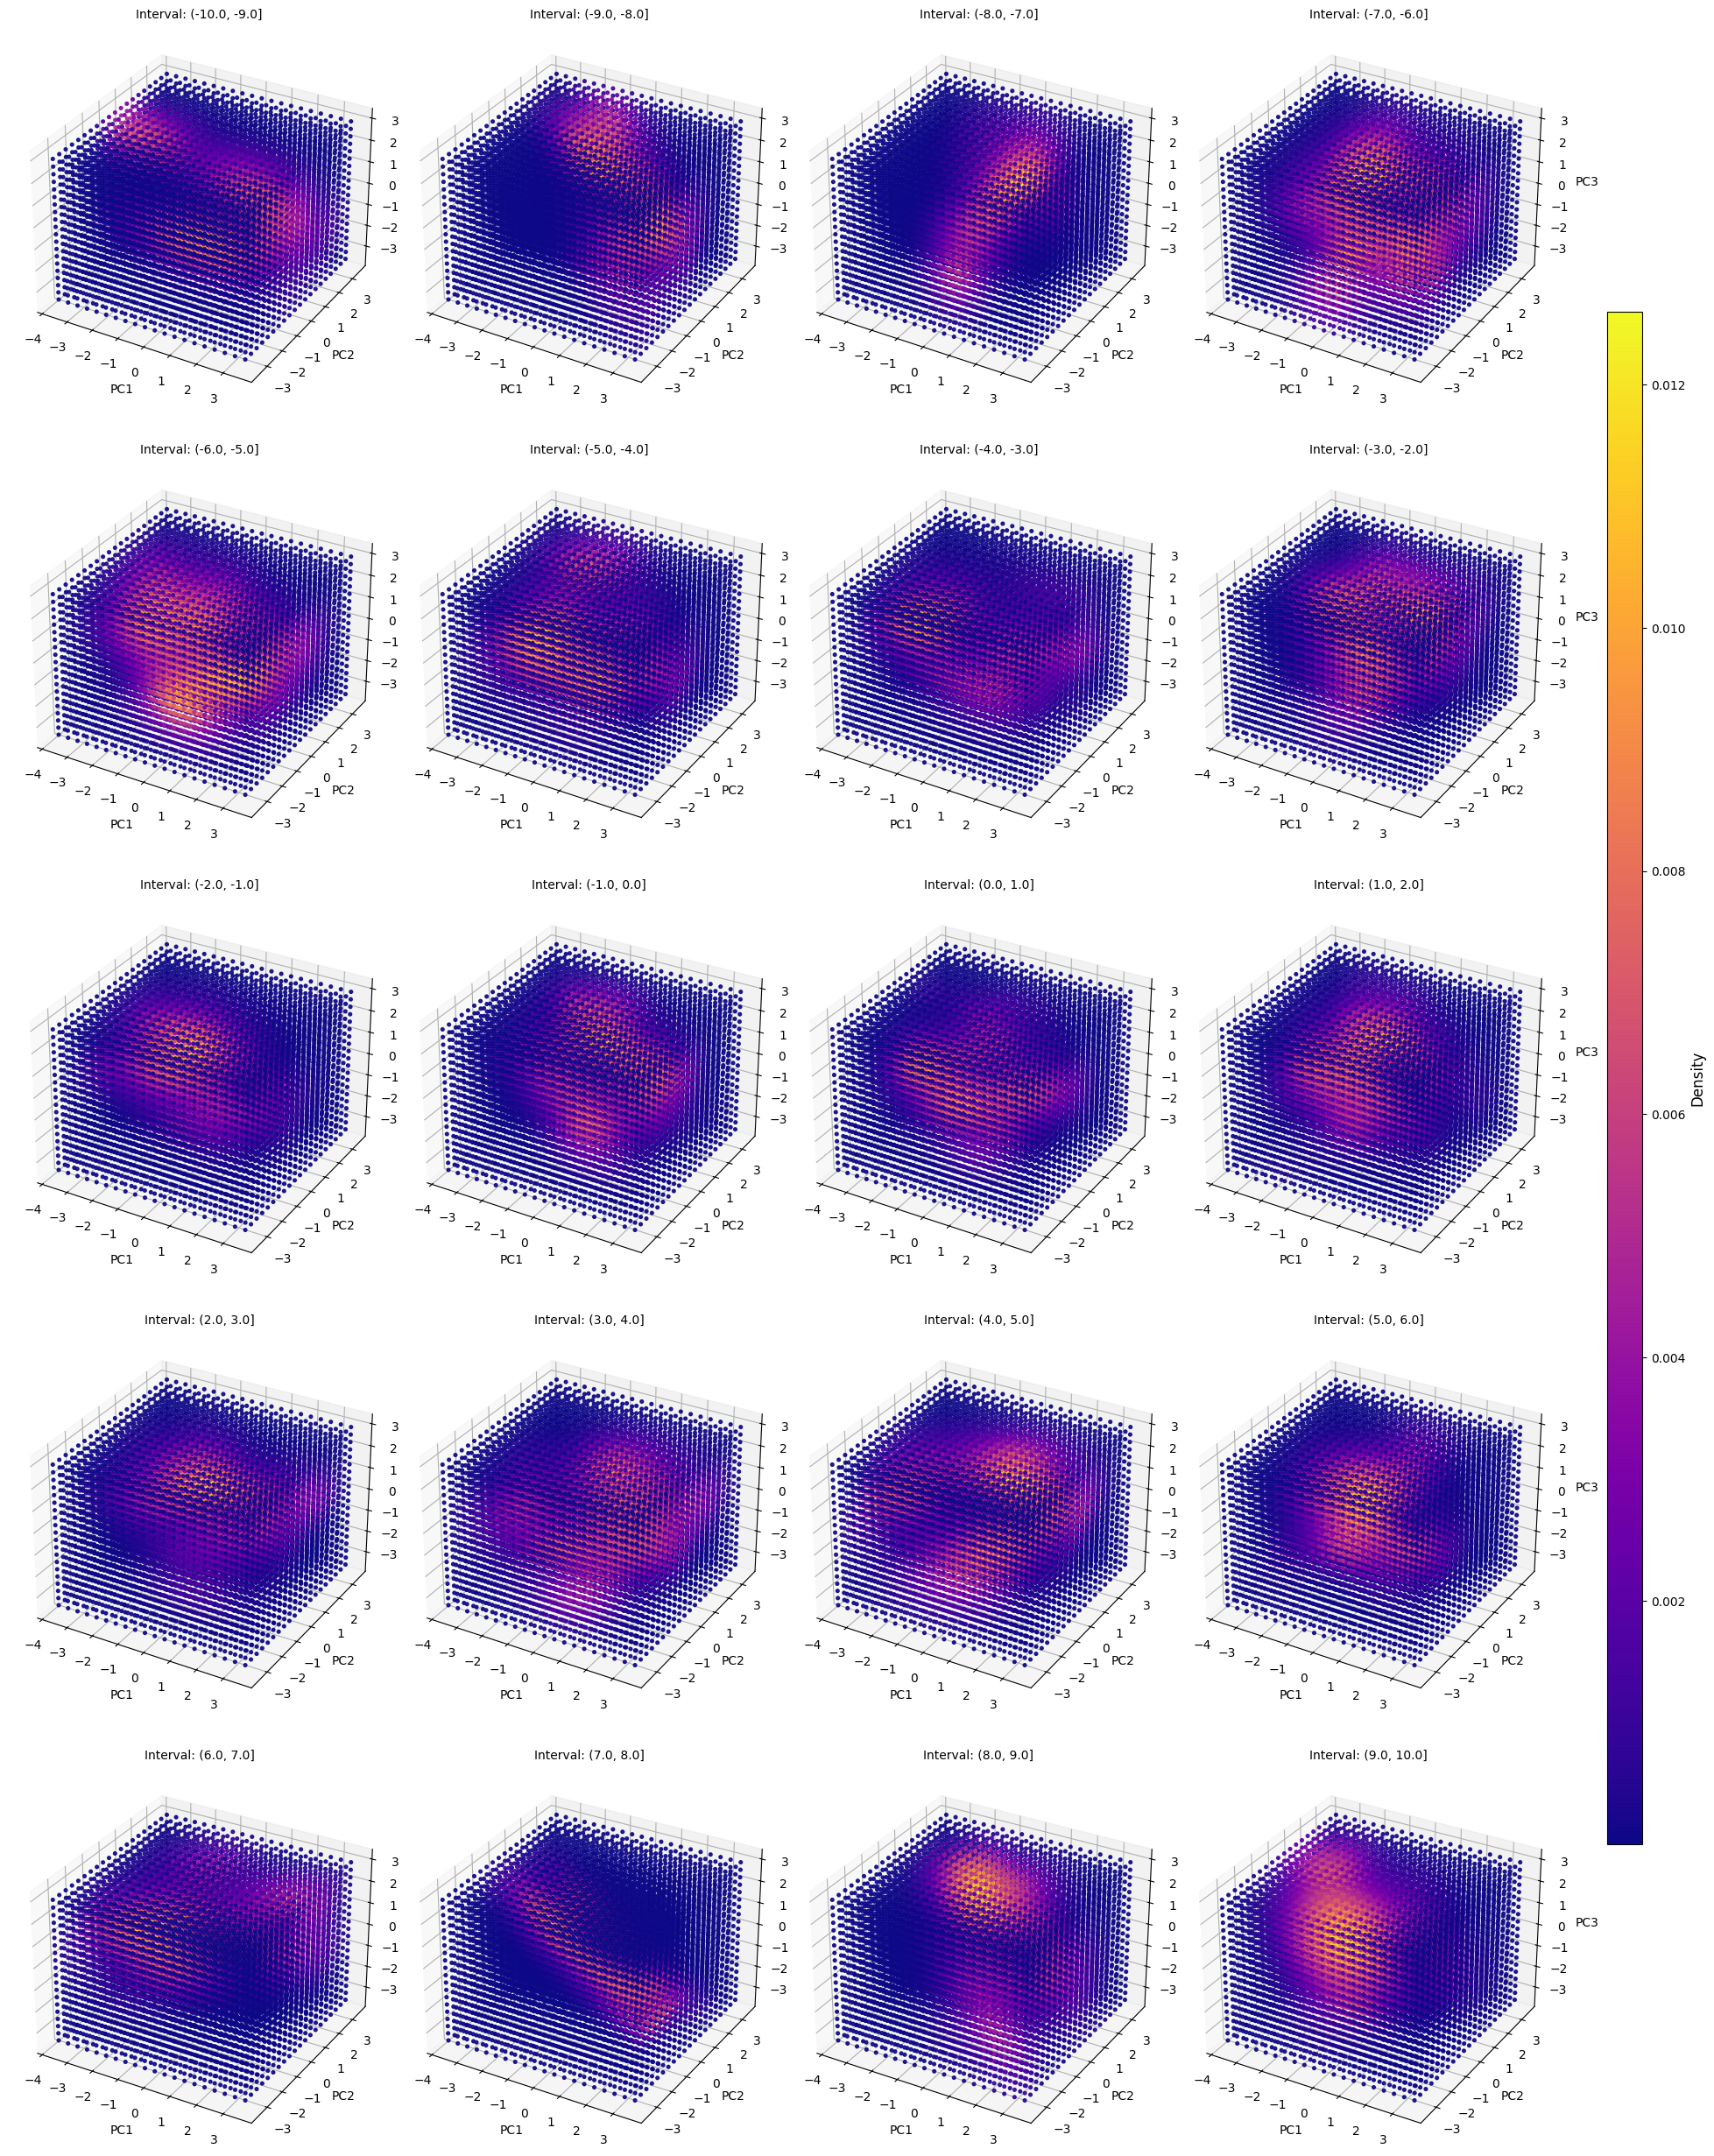

In [229]:
fig = plt.figure(figsize=(20, 25))  # 전체 플롯 크기 설정
num_intervals = len(kde_dict)  # interval 개수 확인
rows, cols = 5, 4  # 5행 4열 설정

for idx, (interval, kde) in enumerate(kde_dict.items()):
    if idx >= rows * cols:
        break  # 서브플롯 개수를 초과하면 중단

    selected_interval = interval
    selected_kde = kde

    # 각 축의 범위 지정
    pc1_range = np.linspace(final_data['PC1'].min(), final_data['PC1'].max(), 20)
    pc2_range = np.linspace(final_data['PC2'].min(), final_data['PC2'].max(), 20)
    pc3_range = np.linspace(final_data['PC3'].min(), final_data['PC3'].max(), 20)

    # 3D 격자점 생성
    PC1, PC2, PC3 = np.meshgrid(pc1_range, pc2_range, pc3_range, indexing='ij')

    positions = np.vstack([PC1.ravel(), PC2.ravel(), PC3.ravel()])
    kde_values = selected_kde(positions).reshape(PC1.shape)

    # 각 서브플롯에 KDE 시각화
    ax = fig.add_subplot(rows, cols, idx + 1, projection='3d')
    norm = cm.colors.Normalize(vmin=kde_values.min(), vmax=kde_values.max())
    cmap = cm.plasma

    scatter = ax.scatter(
        PC1.ravel(), PC2.ravel(), PC3.ravel(),
        c=kde_values.ravel(), cmap=cmap, s=7, alpha=0.9, norm=norm
    )

    ax.set_title(f"Interval: {selected_interval}", fontsize=10)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

# 공통 색상 막대 생성
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
norm = cm.colors.Normalize(vmin=kde_values.min(), vmax=kde_values.max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label("Density", fontsize=12)

# 서브플롯 간격 조정
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

## 사전 분포 갱신

In [499]:
update_data.reset_index(drop=True, inplace=True)
pred_data.reset_index(drop=True, inplace=True)

In [500]:
posterior_df = prior_df.copy()

In [501]:
UPDATE_NUM = 1

In [502]:
# close_pct로 interval 구하는 함수

def get_interval(value):
  for interval in theta_intervals:
    if interval.left <= value <= interval.right:
      return interval

In [503]:
# 업데이트 데이터에 없는 구간 확인하는 함수

def check_interval(update_data):
  intervals = []
  for i in range(len(update_data)):
    interval = get_interval(update_data.loc[i, 'close_pct'])
    intervals.append(str(interval))
  intervals = pd.Series(intervals)
  check = intervals.unique()
  missing_intervals = set(map(str, theta_intervals)) - set(check)

  return missing_intervals

In [504]:
# 사후확률 업데이트 함수

def update_posterior_probabilities(update_data, kde_dict, posterior_df):


    global UPDATE_NUM
    for i in range(len(update_data)):
      PC1, PC2, PC3 = update_data.loc[i, ['PC1', 'PC2', 'PC3']]
      interval = get_interval(update_data.loc[i, 'close_pct'])
      value = (PC1, PC2, PC3)
      likelihood = kde_dict[str(interval)].evaluate(value)

      # 사후확률이 0이 되는 것을 방지
      epsilon = 1e-6
      if np.isnan(likelihood) or likelihood == 0:
        likelihood = epsilon

      if UPDATE_NUM == 1:
        prior_probability = posterior_df[posterior_df['theta_interval'] == str(interval)]['prior_probability']
      else:
        prior_probability = posterior_df[posterior_df['theta_interval'] == str(interval)][f'posterior_probability{UPDATE_NUM-1}']

      posterior_probability = likelihood * prior_probability
      posterior_df.loc[
          posterior_df['theta_interval'] == str(interval), f'posterior_probability{UPDATE_NUM}'
      ] = posterior_probability


    # 업데이트 데이터에 없는 구간 보정
    epsilon = 1e-6
    missing_intervals = check_interval(update_data)
    if missing_intervals:
      for interval in missing_intervals:
        if UPDATE_NUM == 1:
          posterior_df.loc[
              posterior_df['theta_interval'] == str(interval), f'posterior_probability{UPDATE_NUM}'
          ] = epsilon * posterior_df['prior_probability']
        else:
          posterior_df.loc[
              posterior_df['theta_interval'] == str(interval), f'posterior_probability{UPDATE_NUM}'
          ] = epsilon * posterior_df[f'posterior_probability{UPDATE_NUM-1}']

    # 사후확률 정규화
    posterior_df[f'posterior_probability{UPDATE_NUM}'] /= posterior_df[f'posterior_probability{UPDATE_NUM}'].sum()
    UPDATE_NUM += 1

    return posterior_df

### 첫 번째 업데이트

In [505]:
posterior_df = update_posterior_probabilities(update_data, kde_dict, posterior_df)

In [506]:
display(posterior_df['posterior_probability1'].sum())
display(posterior_df.head(3))

1.0

theta_interval  prior_probability  posterior_probability1
0  (-10.0, -9.0]           0.002134                0.005114
1   (-9.0, -8.0]           0.004733                0.000661
2   (-8.0, -7.0]           0.009615                0.012326

### 사후 분포 시각화

In [507]:
mean = 0

for idx, v in enumerate(range(-10, 10)):
  mean += (v+0.5) * posterior_df['posterior_probability1'][idx]
  print(mean)

mean /= 20

print("this: ", mean)

-0.04858518067579609
-0.05420426100928675
-0.14664604152996952
-0.14827363725040957
-0.5194659010630367
-0.5856716552748802
-0.5894349896486142
-0.8558309644176555
-1.0767669293090865
-1.1074413158192355
-1.028295789818149
-0.7707660495544865
-0.5664390115167416
-0.5408130004726327
-0.4524699195750961
-0.04039838741244872
0.35387892716743624
0.35387958552597
0.3884916353682424
0.4346586187772147
this:  0.021732930938860733


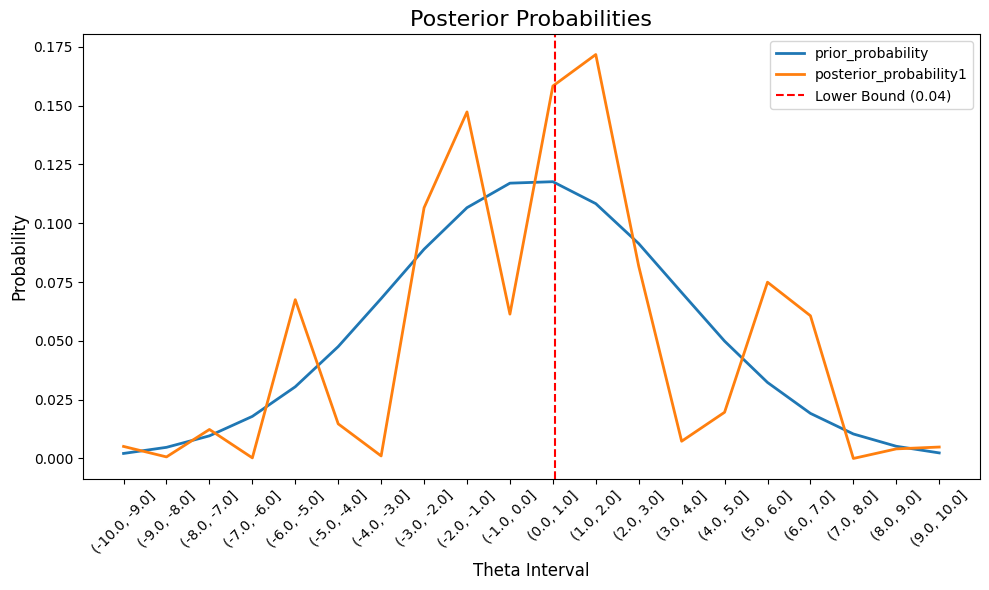

In [508]:
import matplotlib.pyplot as plt

# 그래프 그리기
ax = posterior_df.plot(
    x='theta_interval',
    y=["prior_probability", "posterior_probability1"],
    kind='line',
    figsize=(10, 6),  # 그래프를 가로로 길게 설정
    linewidth=2
)
plt.title("Posterior Probabilities", fontsize=16)
plt.xlabel("Theta Interval", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.xticks(range(len(theta_intervals)), labels=theta_intervals, rotation=45, fontsize=10)
plt.axvline(10.03978, color='red', linestyle='--', label=f'Lower Bound ({0.03978:.2f})')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# 경제 데이터

In [509]:
h0_cols = ['close_pct', 'mfi', 'williams', 'date']
h0_data = data.copy()[h0_cols]
h0_data.head(3)

close_pct        mfi  williams        date
0   0.037266  54.406803 -7.404349  2017-08-30
1   0.023285  57.451006 -1.525918  2017-08-31
2  -0.075031  68.335974 -3.408838  2017-09-01

## 경제 데이터 분포 확인

array([[<Axes: title={'center': 'close_pct'}>,
        <Axes: title={'center': 'mfi'}>],
       [<Axes: title={'center': 'williams'}>, <Axes: >]], dtype=object)

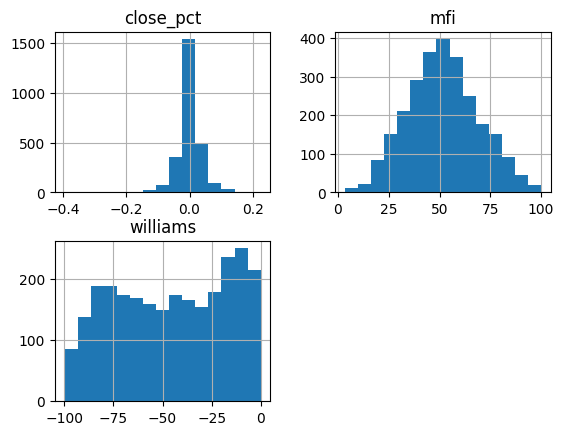

In [510]:
h0_data.hist(bins=15)

## 경제 데이터 상관관계 분석

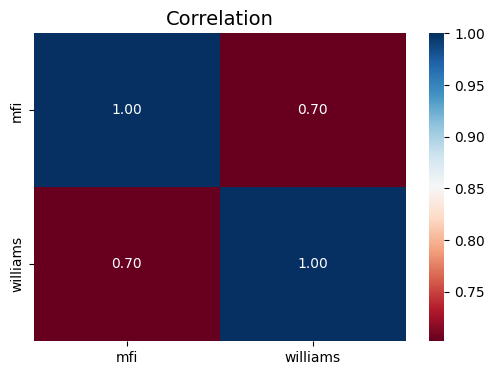

In [511]:
import seaborn as sns

# 상관 행렬 계산
cor_matrix = h0_data.drop(['date', 'close_pct'], axis=1).corr()

# 히트맵 생성
plt.figure(figsize=(6, 4))  # 크기 조정
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap="RdBu", cbar=True)
plt.title("Correlation", fontsize=14)
plt.show()

## 경제 데이터 PCA

In [512]:
numeric_data = h0_data.drop(['date', 'close_pct'], axis=1)

# 데이터 표준화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(numeric_data)

# PCA 수행
pca = PCA()
pca_result = pca.fit_transform(data_scaled)
pca_df_h0 = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(len(pca.components_))])

# PCA 분산 설명도
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.8510788, 0.1489212])

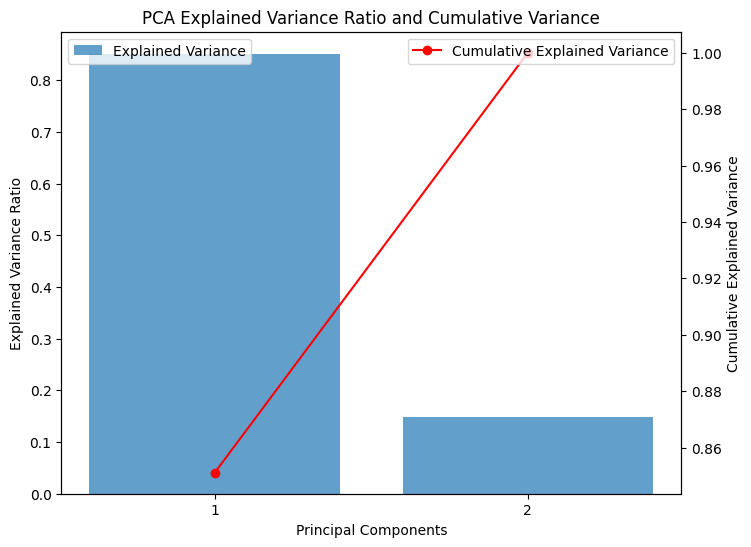

In [513]:
ig, ax1 = plt.subplots(figsize=(8, 6))

# 설명 분산 확인을 위한 막대 그래프
ax1.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Explained Variance')
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_xticks(range(1, len(explained_variance) + 1))
ax1.legend(loc='upper left')

# 설명 분산 확인을 위한 선 그래프
ax2 = ax1.twinx()
ax2.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', color='red', label='Cumulative Explained Variance')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.legend(loc='upper right')

plt.title('PCA Explained Variance Ratio and Cumulative Variance')
plt.show()

In [514]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=numeric_data.columns
)
loadings

PC1       PC2
mfi       0.707107 -0.707107
williams  0.707107  0.707107

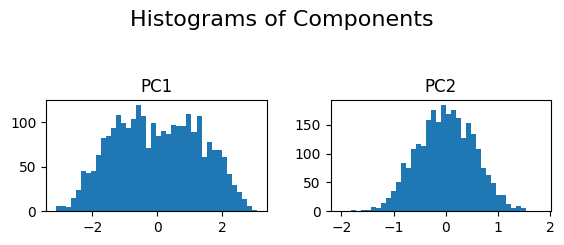

In [515]:
pca_df_h0[['PC1', 'PC2']].hist(bins=40, figsize=(6, 4), layout=(2, 2), grid=False)
plt.suptitle("Histograms of Components", fontsize=16)  # 공통 제목
plt.tight_layout(pad=2.0)
plt.show()

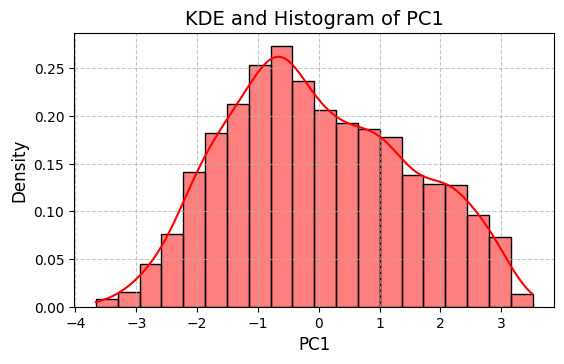

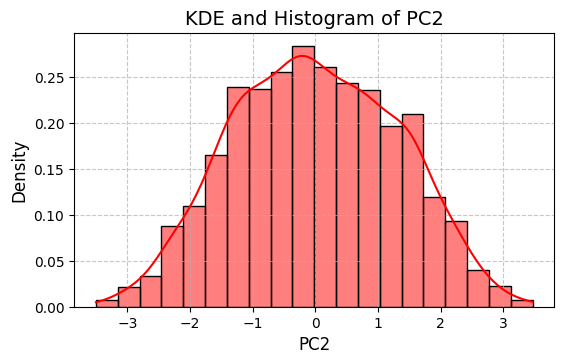

In [516]:
# PCA 컴포넌트 히스토그램 생성
components = ['PC1', 'PC2']

for i, component in enumerate(components, 1):
    plt.figure(figsize=(6, 4))
    sns.histplot(pca_df[component], bins=20, kde=True, color='red', edgecolor='black', stat="density")
    plt.xlabel(component, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(f"KDE and Histogram of {component}", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)  # 격자 추가
    plt.tight_layout(pad=2.0)
    plt.show()

## 경제 데이터 날짜, close_pct 열과 merge

In [517]:
pca_df_h0 = pca_df[["PC1", "PC2"]]
pca_df_h0.set_index(data["date"], inplace = True)

In [518]:
pca_df_h0 = pd.merge(pca_df_h0, h0_data[["date", "close_pct"]], left_on = pca_df_h0.index, right_on = 'date', how = 'left')
pca_df_h0["close_pct"] *= 100
final_data_h0 = pca_df_h0.copy()
final_data_h0.head(3)

PC1       PC2        date  close_pct
0 -0.379293  0.917002  2017-08-30   3.726559
1 -0.781118  1.315675  2017-08-31   2.328520
2 -1.450274  2.082058  2017-09-01  -7.503139

## 경제 데이터 변동률 10% 초과 데이터 삭제

In [519]:
tmp_h0 = final_data_h0[final_data_h0["close_pct"] > 10]
tmp2_h0 = final_data_h0[final_data_h0["close_pct"] < -10]
final_data_h0.drop(tmp_h0.index, inplace = True)
final_data_h0.drop(tmp2_h0.index, inplace = True)

## 경제 데이터 분할

In [520]:
from sklearn.model_selection import train_test_split

def_data_h0, update_data_h0 = train_test_split(final_data_h0, test_size=0.7, shuffle=False)
update_data_h0, pred_data_h0 = train_test_split(update_data_h0, test_size=0.5, shuffle=False)

## 경제 데이터 가능도 함수 생성

In [521]:
from scipy.stats import gaussian_kde

h0_data_for_kde = def_data[['PC1', 'PC2']]

# 커널 밀도 추정 : PC1, PC2, PC3의 결합밀도함수 생성
kde_h0 = gaussian_kde(h0_data_for_kde.T)

In [522]:
# 변동률 구간별 가능도 함수 딕셔너리
kde_dict_h0 = {}

for interval in theta_intervals:
    subset_h0 = def_data_h0[(def_data_h0['close_pct'] > interval.left) & (def_data_h0['close_pct'] <= interval.right)][['PC1', 'PC2']].dropna()

    print(subset_h0.shape)

    kde_h0 = gaussian_kde(subset_h0.T)
    kde_dict_h0[str(interval)] = kde_h0

(6, 2)
(8, 2)
(9, 2)
(18, 2)
(21, 2)
(21, 2)
(39, 2)
(40, 2)
(72, 2)
(131, 2)
(133, 2)
(94, 2)
(52, 2)
(42, 2)
(24, 2)
(20, 2)
(10, 2)
(10, 2)
(9, 2)
(5, 2)


### 경제 데이터 가능도 함수 시각화

<ipython-input-369-26857cec6299>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


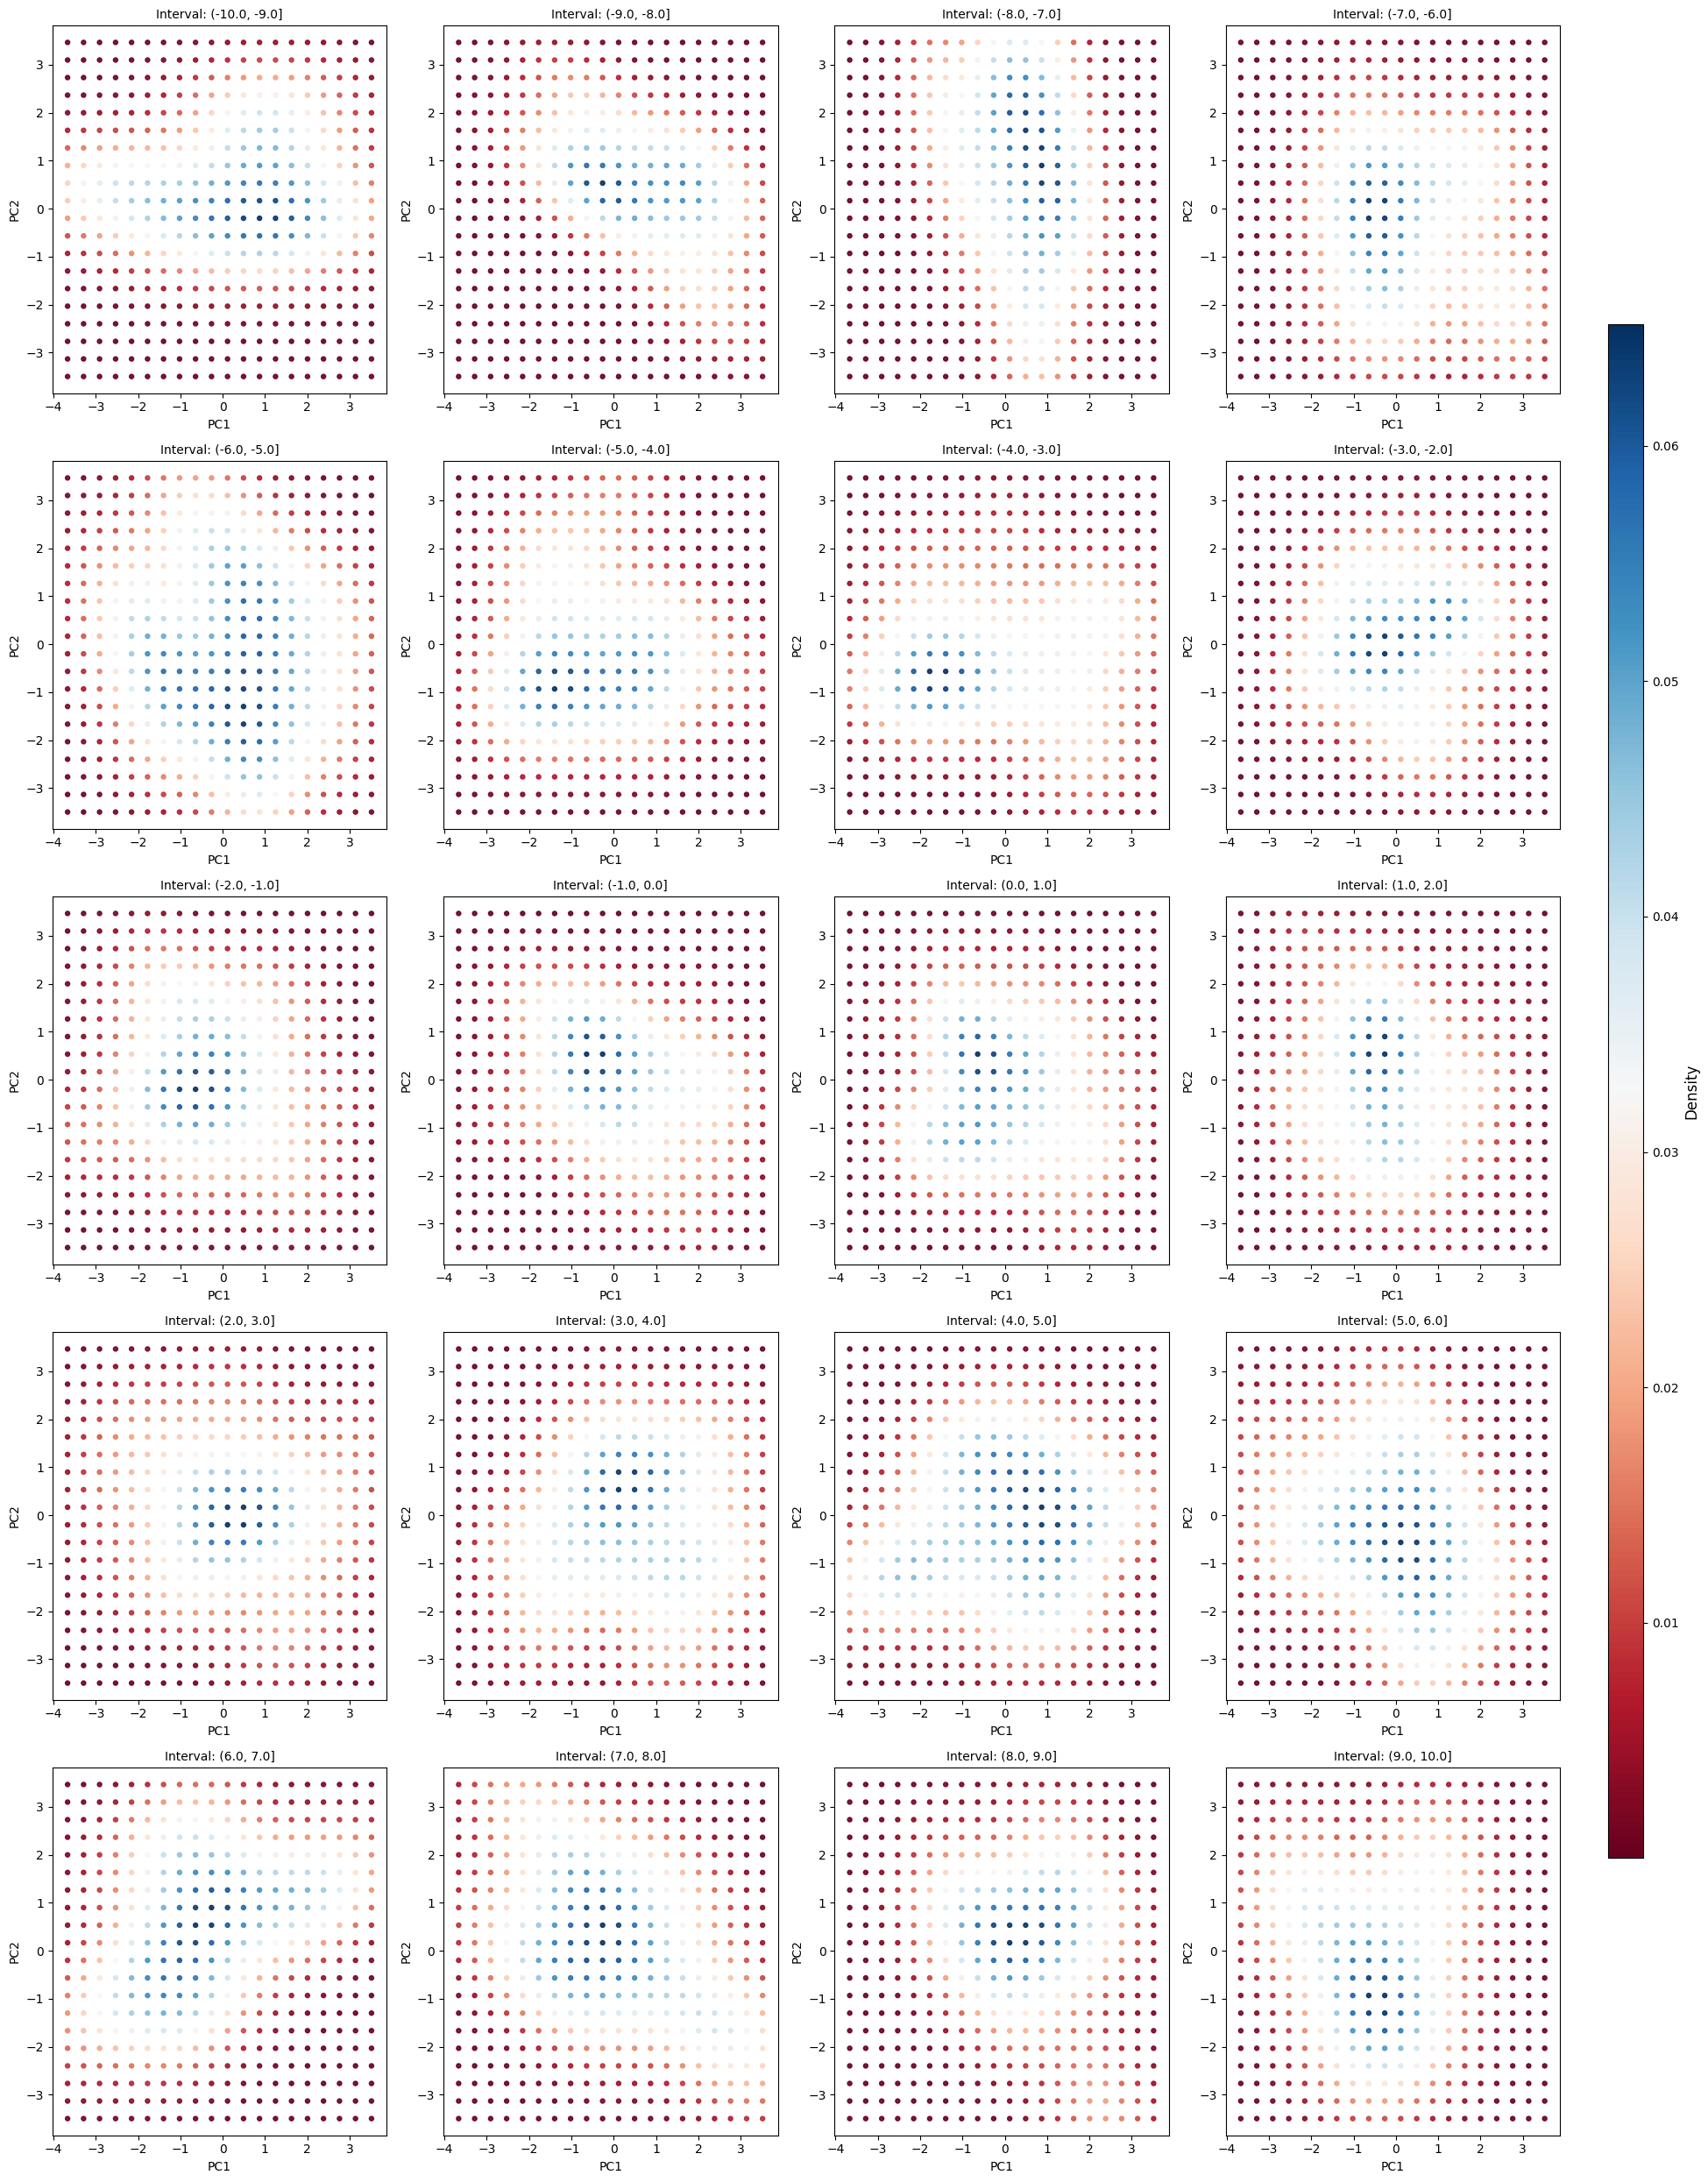

In [369]:
fig = plt.figure(figsize=(20, 25))  # 전체 플롯 크기 설정
num_intervals = len(kde_dict_h0)  # interval 개수 확인
rows, cols = 5, 4  # 5행 4열 설정

for idx, (interval, kde) in enumerate(kde_dict_h0.items()):
    if idx >= rows * cols:
        break  # 서브플롯 개수를 초과하면 중단

    selected_interval = interval
    selected_kde = kde

    # 각 축의 범위 지정
    pc1_range = np.linspace(final_data_h0['PC1'].min(), final_data_h0['PC1'].max(), 20)
    pc2_range = np.linspace(final_data_h0['PC2'].min(), final_data_h0['PC2'].max(), 20)

    # 3D 격자점 생성
    PC1, PC2 = np.meshgrid(pc1_range, pc2_range, indexing='ij')

    positions = np.vstack([PC1.ravel(), PC2.ravel()])
    kde_values = selected_kde(positions).reshape(PC1.shape)

    # 각 서브플롯에 KDE 시각화
    ax = fig.add_subplot(rows, cols, idx + 1)
    norm = cm.colors.Normalize(vmin=kde_values.min(), vmax=kde_values.max())
    cmap = cm.RdBu

    scatter = ax.scatter(
        PC1.ravel(), PC2.ravel(),
        c=kde_values.ravel(), cmap=cmap, s=13, alpha=0.9, norm=norm
    )

    ax.set_title(f"Interval: {selected_interval}", fontsize=10)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

# 공통 색상 막대 생성
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
norm = cm.colors.Normalize(vmin=kde_values.min(), vmax=kde_values.max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label("Density", fontsize=12)

# 서브플롯 간격 조정
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

## 경제 사전 분포 갱신

In [523]:
update_data_h0.reset_index(drop=True, inplace=True)
pred_data_h0.reset_index(drop=True, inplace=True)

In [524]:
# 사후확률 업데이트 함수

def update_posterior_probabilities(update_data, kde_dict, posterior_df):

    global UPDATE_NUM
    for i in range(len(update_data)):
      PC1, PC2 = update_data.loc[i, ['PC1', 'PC2']]
      interval = get_interval(update_data.loc[i, 'close_pct'])
      value = (PC1, PC2)
      likelihood = kde_dict[str(interval)].evaluate(value)

      # 사후확률이 0이 되는 것을 방지
      epsilon = 1e-6
      if np.isnan(likelihood) or likelihood == 0:
        likelihood = epsilon

      if UPDATE_NUM == 1:
        prior_probability = posterior_df[posterior_df['theta_interval'] == str(interval)]['prior_probability']
      else:
        prior_probability = posterior_df[posterior_df['theta_interval'] == str(interval)][f'posterior_probability{UPDATE_NUM-1}']

      posterior_probability = likelihood * prior_probability
      posterior_df.loc[
          posterior_df['theta_interval'] == str(interval), f'posterior_probability{UPDATE_NUM}'
      ] = posterior_probability


    # 업데이트 데이터에 없는 구간 보정
    epsilon = 1e-6
    missing_intervals = check_interval(update_data)
    if missing_intervals:
      for interval in missing_intervals:
        if UPDATE_NUM == 1:
          posterior_df.loc[
              posterior_df['theta_interval'] == str(interval), f'posterior_probability{UPDATE_NUM}'
          ] = epsilon * posterior_df['prior_probability']
        else:
          posterior_df.loc[
              posterior_df['theta_interval'] == str(interval), f'posterior_probability{UPDATE_NUM}'
          ] = epsilon * posterior_df[f'posterior_probability{UPDATE_NUM-1}']

    # 사후확률 정규화
    posterior_df[f'posterior_probability{UPDATE_NUM}'] /= posterior_df[f'posterior_probability{UPDATE_NUM}'].sum()
    UPDATE_NUM += 1

    return posterior_df

### 경제 첫 번째 업데이트

In [525]:
posterior_df_h0 = prior_df.copy()

In [526]:
UPDATE_NUM = 1

In [527]:
posterior_df_h0 = update_posterior_probabilities(update_data_h0, kde_dict_h0, posterior_df_h0)

In [528]:
display(posterior_df_h0['posterior_probability1'].sum())
display(posterior_df_h0.head(3))

1.0000000000000002

theta_interval  prior_probability  posterior_probability1
0  (-10.0, -9.0]           0.002134                0.004352
1   (-9.0, -8.0]           0.004733                0.001950
2   (-8.0, -7.0]           0.009615                0.011333

### 경제 사후 분포 시각화

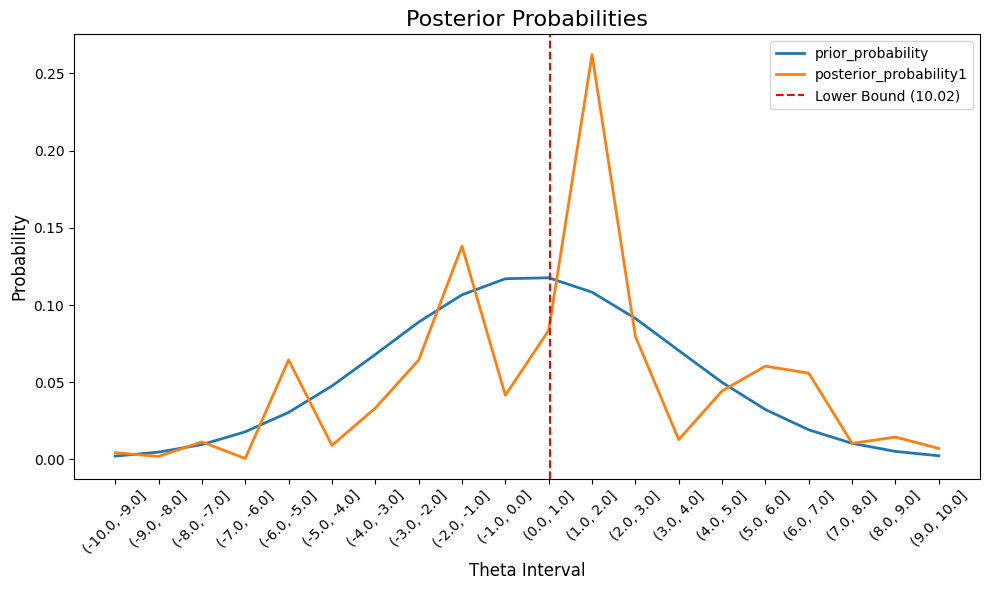

In [529]:
import matplotlib.pyplot as plt

# 그래프 그리기
ax = posterior_df_h0.plot(
    x='theta_interval',
    y=["prior_probability", "posterior_probability1"],
    kind='line',
    figsize=(10, 6),  # 그래프를 가로로 길게 설정
    linewidth=2
)
plt.title("Posterior Probabilities", fontsize=16)
plt.xlabel("Theta Interval", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.xticks(range(len(theta_intervals)), labels=theta_intervals, rotation=45, fontsize=10)
plt.axvline(10.021732, color='red', linestyle='--', label=f'Lower Bound ({10.021732:.2f})')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [530]:
posterior_df_h0

theta_interval  prior_probability  posterior_probability1
0   (-10.0, -9.0]           0.002134                0.004352
1    (-9.0, -8.0]           0.004733                0.001950
2    (-8.0, -7.0]           0.009615                0.011333
3    (-7.0, -6.0]           0.017887                0.000621
4    (-6.0, -5.0]           0.030475                0.064470
5    (-5.0, -4.0]           0.047552                0.009076
6    (-4.0, -3.0]           0.067953                0.033245
7    (-3.0, -2.0]           0.088934                0.064324
8    (-2.0, -1.0]           0.106596                0.138140
9     (-1.0, 0.0]           0.117013                0.041532
10     (0.0, 1.0]           0.117636                0.083552
11     (1.0, 2.0]           0.108309                0.262196
12     (2.0, 3.0]           0.091328                0.079707
13     (3.0, 4.0]           0.070527                0.012837
14     (4.0, 5.0]           0.049880                0.044350
15     (5.0, 6.0]           0.032309                0.060426
16     (6.0, 7.0]           0.019166                0.055868
17     (7.0, 8.0]           0.010412                0.010419
18     (8.0, 9.0]           0.005181                0.014474
19    (9.0, 10.0]           0.002361                0.007127

In [531]:
mean = 0

for idx, v in enumerate(range(-10, 10)):
  mean += (v+0.5) * posterior_df_h0['posterior_probability1'][idx]
  print(mean)

mean /= 20

print("this: ", mean)

-0.04134858167056343
-0.05791999115428755
-0.14292040973888576
-0.14695480998807567
-0.5015380828189215
-0.5423822090534146
-0.6587408480101317
-0.8195506489739509
-1.0267608367687062
-1.0475269952995607
-1.0057510480359444
-0.6124563268367572
-0.4131890867912343
-0.36826088217258385
-0.16868409897331113
0.16365855650855057
0.5267975288319746
0.6049371666916488
0.7279685835483116
0.7956784628601802
this:  0.039783923143009006


array([[<Axes: title={'center': 'PC1'}>, <Axes: title={'center': 'PC2'}>],
       [<Axes: title={'center': 'PC3'}>,
        <Axes: title={'center': 'close_pct'}>]], dtype=object)

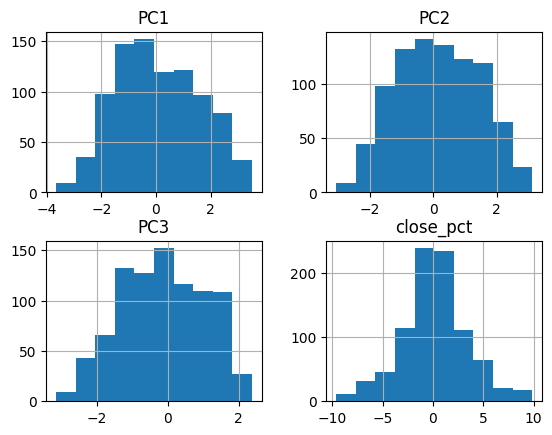

In [532]:
update_data.hist()

# PPC

## 채택기각법을 활용한 샘플링

In [533]:
# 구간 경계 추출
interval_edges = np.linspace(-10, 10, 21)  # 구간 경계

# 제안 분포: 균일 분포에서 샘플 생성
proposal_samples = np.random.randint(-10, 10, size=10000)

In [534]:
proposal_samples

array([ 9, -2,  6, ..., -7,  2, -7])

In [535]:
def posterior_prob(x, posterior_df, interval_edges):
    for i in range(len(interval_edges) - 1):
        if interval_edges[i] <= x < interval_edges[i + 1]:
            return posterior_df.iloc[i]['posterior_probability1']
    return 0  # 구간 외 값의 확률은 0

In [536]:
# 사후 확률 계산
proposal_probs_d1 = np.array([posterior_prob(x, posterior_df, interval_edges) for x in proposal_samples])
proposal_probs_d0 = np.array([posterior_prob(x, posterior_df_h0, interval_edges) for x in proposal_samples])

# M: 사후분포의 최대 확률값
M_d1 = posterior_df['posterior_probability1'].max()
M_d0 = posterior_df_h0['posterior_probability1'].max()

# 랜덤 값 생성
u_d1 = np.random.uniform(0, M_d1, size=proposal_samples.shape)
u_d0 = np.random.uniform(0, M_d0, size=proposal_samples.shape)

# 채택 조건
accepted_samples_d1 = proposal_samples[proposal_probs_d1 >= u_d1]
accepted_samples_d0 = proposal_samples[proposal_probs_d0 >= u_d0]

평균 채택 시도: 348.31069313827936 
alpha: 3.4337298701821686


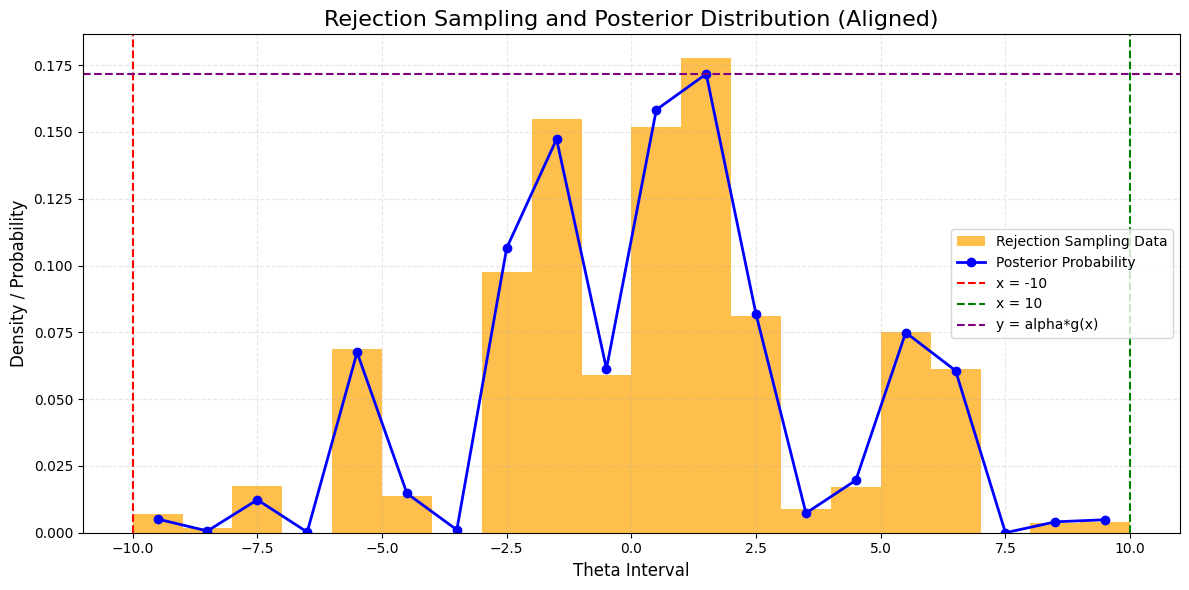

평균 채택 시도: 518.9413596263622 
alpha: 5.243929615989162


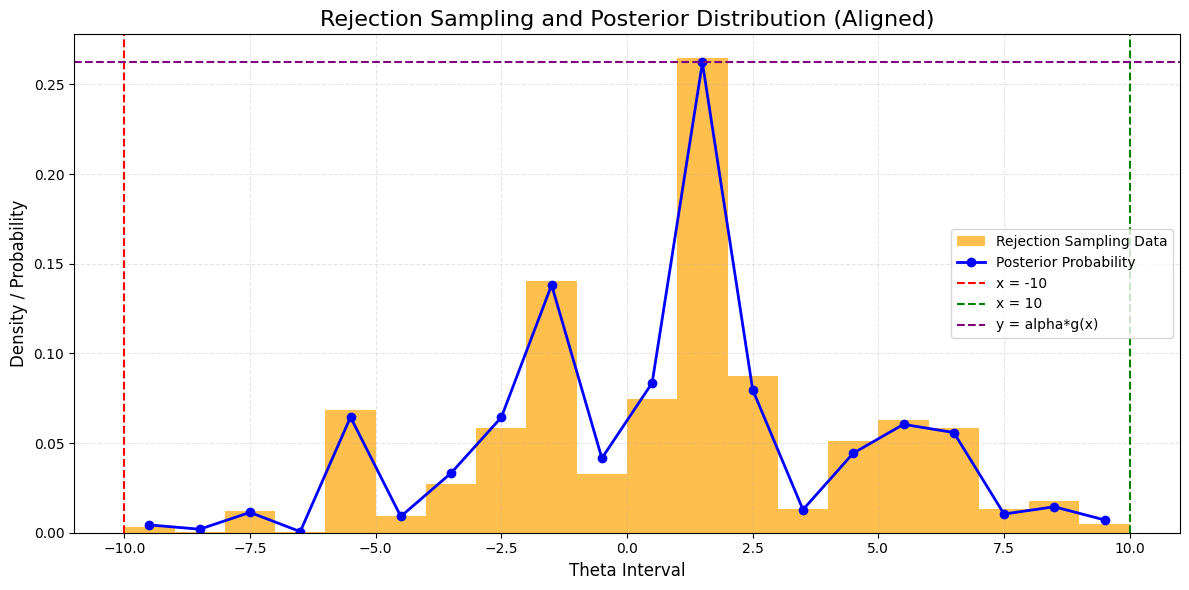

In [537]:
def plot_rejection_sampling_distribution_fixed(samples, theta_intervals, posterior_df, accepted_samples):
    # 경계값을 bins으로 설정
    bin_edges = [interval.left for interval in theta_intervals] + [theta_intervals[-1].right]

    plt.figure(figsize=(12, 6))

    # 히스토그램: 샘플링된 데이터
    plt.hist(
        samples,
        bins=bin_edges,
        alpha=0.7,
        label="Rejection Sampling Data",
        density=True,
        color="orange",
        align="mid",
    )

    # 선 그래프: Posterior 분포
    plt.plot(
        [interval.mid for interval in theta_intervals],
        posterior_df['posterior_probability1'],
        label="Posterior Probability",
        color="blue",
        marker="o",
        linewidth=2,
    )

    alpha = posterior_df['posterior_probability1'].max()*20

    # 추가 선: x = -10, x = 10, y = 0.2429
    plt.axvline(x=-10, color='red', linestyle='--', label="x = -10")
    plt.axvline(x=10, color='green', linestyle='--', label="x = 10")
    plt.axhline(y=alpha*(1/20), color='purple', linestyle='--', label="y = alpha*g(x)")

    print(f"평균 채택 시도: {1000000/len(accepted_samples)} \nalpha: {alpha}")

    plt.title("Rejection Sampling and Posterior Distribution (Aligned)", fontsize=16)
    plt.xlabel("Theta Interval", fontsize=12)
    plt.ylabel("Density / Probability", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.show()

# 수정된 분포 시각화
plot_rejection_sampling_distribution_fixed(accepted_samples_d1, theta_intervals, posterior_df, accepted_samples_d1)
plot_rejection_sampling_distribution_fixed(accepted_samples_d0, theta_intervals, posterior_df_h0, accepted_samples_d0)

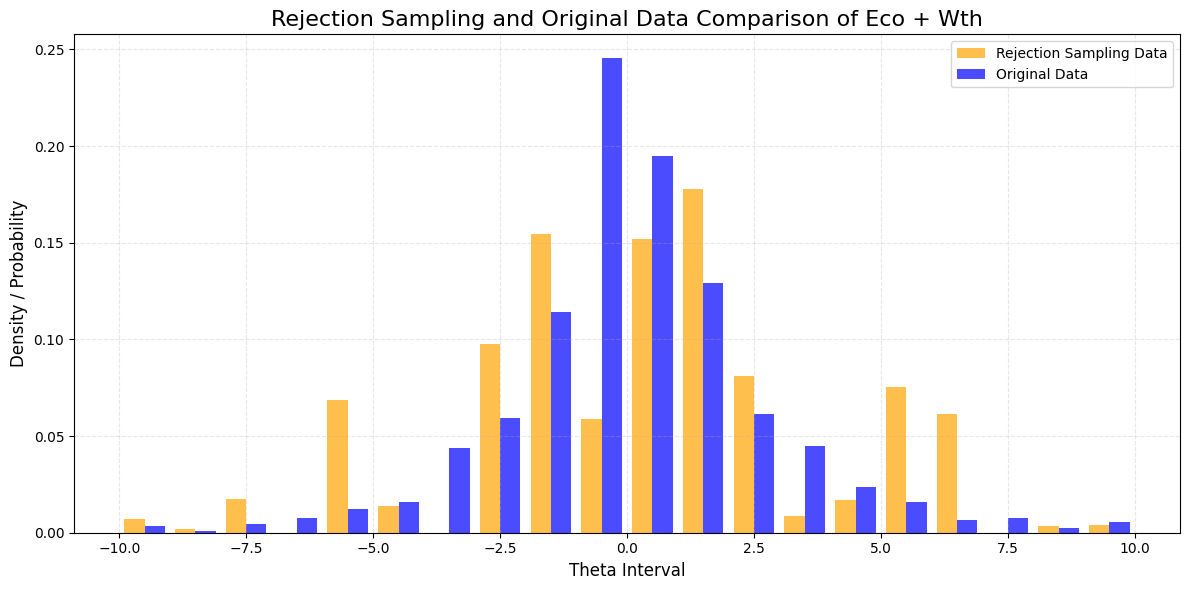

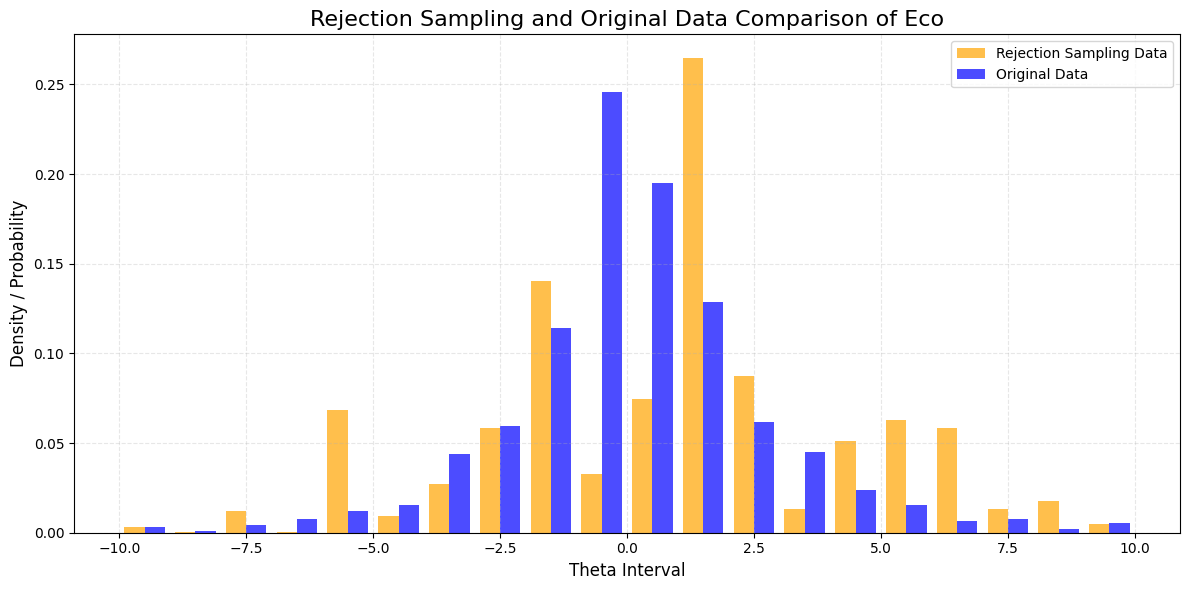

In [538]:
def plot_rejection_sampling_distribution_fixed(samples, theta_intervals, posterior_df, final_data, title):
    import numpy as np
    import matplotlib.pyplot as plt

    # 경계값을 bins으로 설정
    bin_edges = [interval.left for interval in theta_intervals] + [theta_intervals[-1].right]
    bin_centers = np.array([interval.mid for interval in theta_intervals])  # 구간 중심

    # 채택된 샘플 히스토그램
    sample_hist, _ = np.histogram(samples, bins=bin_edges, density=True)

    # 원본 데이터 히스토그램
    original_hist, _ = np.histogram(pred_data['close_pct'], bins=bin_edges, density=True)

    # 막대 그래프 너비
    bar_width = (bin_edges[1] - bin_edges[0]) * 0.4  # 구간 너비의 40%로 설정

    plt.figure(figsize=(12, 6))

    # 첫 번째 데이터: 샘플링된 데이터
    plt.bar(
        bin_centers - bar_width / 2,  # 막대를 왼쪽으로 이동
        sample_hist,
        width=bar_width,
        alpha=0.7,
        label="Rejection Sampling Data",
        color="orange",
    )

    # 두 번째 데이터: 원본 데이터
    plt.bar(
        bin_centers + bar_width / 2,  # 막대를 오른쪽으로 이동
        original_hist,
        width=bar_width,
        alpha=0.7,
        label="Original Data",
        color="blue",
    )

    plt.title(f"Rejection Sampling and Original Data Comparison of {title}", fontsize=16)
    plt.xlabel("Theta Interval", fontsize=12)
    plt.ylabel("Density / Probability", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.show()

# 수정된 분포 시각화
plot_rejection_sampling_distribution_fixed(accepted_samples_d1, theta_intervals, posterior_df, final_data, title="Eco + Wth")
plot_rejection_sampling_distribution_fixed(accepted_samples_d0, theta_intervals, posterior_df_h0, final_data_h0, title="Eco")

# KL-Divergence를 통한 베이지안 모델 비교

In [539]:
def KLDivergence(arr1, arr2, bins=20):
    arr1_inc = np.copy(arr1)
    arr2_inc = np.copy(arr2)

    # Convert arr1 and arr2 to PDFs using a shared binning
    hist1, bin_edges = np.histogram(arr1_inc, bins=bins, density=True)
    hist2, _ = np.histogram(arr2_inc, bins=bin_edges, density=True)  # Use the same bins

    # Avoid divide-by-zero and ensure no zero values in hist2
    hist1 = np.clip(hist1, 1e-6, None)  # Avoid log(0)
    hist2 = np.clip(hist2, 1e-6, None)  # Avoid division by 0

    # Compute KL Divergence
    kl_div = np.sum(hist1 * np.log(hist1 / hist2))

    return kl_div

In [540]:
def sampling(posterior_df, size=1000):
    interval_edges = np.linspace(-10, 10, 21)
    proposal_samples = np.random.randint(-10, 10, size=size)
    proposal_probs = np.array([posterior_prob(x, posterior_df, interval_edges) for x in proposal_samples])
    M = posterior_df['posterior_probability1'].max()
    u = np.random.uniform(0, M, size=proposal_samples.shape)
    accepted_samples = proposal_samples[proposal_probs >= u]

    return accepted_samples

In [541]:
def Dkl_bootstrap(pos_df, rep = 100):
    acc_samples = []

    for i in range(rep):
        acc_samples.append(KLDivergence(sampling(pos_df), pred_data['close_pct']))

    return acc_samples

In [542]:
Dkl_d1 = Dkl_bootstrap(posterior_df)
Dkl_d0 = Dkl_bootstrap(posterior_df_h0)

In [543]:
from scipy.stats import ttest_ind, t

In [544]:
from scipy.stats import ttest_ind

# 등분산 가정 X
t_stat, p_value = ttest_ind(Dkl_d1, Dkl_d0, equal_var=False, alternative='less')

print("t-statistic:", t_stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("두 집단 사이에 통계적으로 유의한 차이가 있습니다.")
else:
    print("두 집단 사이에 통계적으로 유의한 차이가 없습니다.")


t-statistic: -4.16520516354107
p-value: 2.3229716625328466e-05
두 집단 사이에 통계적으로 유의한 차이가 있습니다.


Degrees of freedom (approx): 197.5812356922438


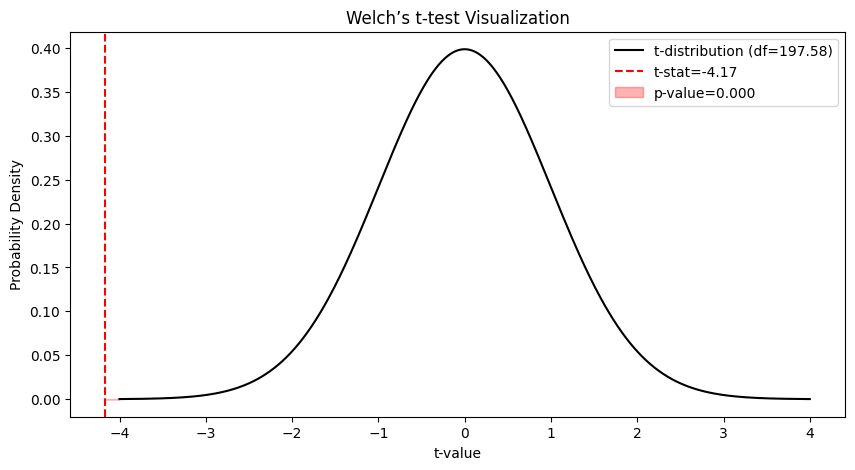

In [545]:
n1 = len(Dkl_d1)
n2 = len(Dkl_d0)
s1_sq = np.var(Dkl_d1, ddof=1)
s2_sq = np.var(Dkl_d0, ddof=1)

num = (s1_sq/n1 + s2_sq/n2)**2
den = ( (s1_sq/n1)**2 / (n1-1) ) + ( (s2_sq/n2)**2 / (n2-1) )
df = num/den

print("Degrees of freedom (approx):", df)

# t-분포를 플롯하기
x = np.linspace(-4, 4, 500)
y = t.pdf(x, df)  # t-분포 pdf

plt.figure(figsize=(10,5))
plt.plot(x, y, label=f't-distribution (df={df:.2f})', color='black')

# t_stat 수직선 표시
plt.axvline(x=t_stat, color='red', linestyle='--', label=f't-stat={t_stat:.2f}')

# p-value 해당 영역 음영 처리 (왼쪽 단측 검정이므로 t_stat 왼쪽 부분)
# p-value는 t_stat보다 왼쪽 영역의 면적
shade_x = np.linspace(-4, t_stat, 200)
shade_y = t.pdf(shade_x, df)
plt.fill_between(shade_x, shade_y, 0, color='red', alpha=0.3, label=f'p-value={p_value:.3f}')

plt.title('Welch’s t-test Visualization')
plt.xlabel('t-value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

# 베이지안 검정

In [546]:
def calculate_intervals_odds(prior_df, posterior_df_h0, posterior_df, custom_interval_1, custom_interval_2):
    """
    사용자 지정 구간에서 Prior Odds와 두 Posterior Odds를 계산하는 함수.
    지정된 구간을 기존의 1% 구간 데이터를 기반으로 동적으로 합산하여 계산.

    Args:
    - prior_df (pd.DataFrame): Prior 분포 데이터프레임 (theta_interval 포함).
    - posterior_df_h0 (pd.DataFrame): H0 가설의 Posterior 분포 데이터프레임.
    - posterior_df (pd.DataFrame): 날씨 데이터를 포함한 Posterior 분포 데이터프레임.
    - custom_interval_1 (tuple): 첫 번째 사용자 지정 구간 (예: (-2.0, 0.0)).
    - custom_interval_2 (tuple): 두 번째 사용자 지정 구간 (예: (0.0, 2.0)).

    Returns:
    - dict: Prior Odds, Posterior Odds (Eco), Posterior Odds (Wth)
    """
    # Index 설정
    prior_df = prior_df.copy()
    posterior_df_h0 = posterior_df_h0.copy()
    posterior_df = posterior_df.copy()

    # Helper function: 사용자 지정 구간의 확률 합산
    def sum_values_in_range(df, custom_interval):
        lower, upper = custom_interval
        df['theta_lower'] = df['theta_interval'].apply(lambda x: float(x.split(',')[0][1:]))
        df['theta_upper'] = df['theta_interval'].apply(lambda x: float(x.split(',')[1][:-1]))
        mask = (df['theta_lower'] >= lower) & (df['theta_upper'] <= upper)
        return df.loc[mask].sum(numeric_only=True)

    # 사용자 지정 구간의 Prior 합산
    prior_sum_1 = sum_values_in_range(prior_df, custom_interval_1)['prior_probability']
    prior_sum_2 = sum_values_in_range(prior_df, custom_interval_2)['prior_probability']
    prior_odds = prior_sum_1 / prior_sum_2

    # 사용자 지정 구간의 Posterior (Eco) 합산
    post_eco_sum_1 = sum_values_in_range(posterior_df_h0, custom_interval_1)['posterior_probability1']
    post_eco_sum_2 = sum_values_in_range(posterior_df_h0, custom_interval_2)['posterior_probability1']
    posterior_odds_eco = post_eco_sum_2 / post_eco_sum_1

    # 사용자 지정 구간의 Posterior (Wth) 합산
    post_wth_sum_1 = sum_values_in_range(posterior_df, custom_interval_1)['posterior_probability1']
    post_wth_sum_2 = sum_values_in_range(posterior_df, custom_interval_2)['posterior_probability1']
    posterior_odds_wth = post_wth_sum_2 / post_wth_sum_1

    # 결과 반환
    return {
        "prior_odds": prior_odds,
        "posterior_odds_eco": posterior_odds_eco,
        "posterior_odds_wth": posterior_odds_wth,
        "bf_eco":  posterior_odds_eco/prior_odds,
        "bf_wth":  posterior_odds_wth/prior_odds
    }

In [547]:
result = calculate_intervals_odds(
    prior_df,
    posterior_df_h0,
    posterior_df,
    custom_interval_1=(-10.0, 0.0),  # 사용자 지정 첫 번째 구간
    custom_interval_2=(0.0, 10.0)   # 사용자 지정 두 번째 구간
)

pd.DataFrame(result, index=['value'])

prior_odds  posterior_odds_eco  posterior_odds_wth    bf_eco    bf_wth
value    0.971967            1.709704            1.399081  1.759014  1.439432

In [548]:
# 변동률 구간 20개로 split

theta_bins = 20
close_pct_range = np.linspace(-10, 10, theta_bins + 1)

prior_probabilities = np.full(theta_bins, 1 / theta_bins)

theta_intervals = pd.IntervalIndex.from_breaks(close_pct_range, closed='right')
final_data['theta_interval'] = pd.cut(final_data['close_pct'], bins=theta_intervals)

theta_prior = pd.DataFrame({
    'theta_interval': theta_intervals,
    'prior_probability': prior_probabilities
})

In [549]:
len(final_data[final_data['close_pct'] > 0]) / len(final_data[final_data['close_pct'] < 0])

1.0507246376811594

# 신뢰구간

## 고전적 신뢰구간

In [397]:
posterior_df_h0

theta_interval  prior_probability  posterior_probability1
0   (-10.0, -9.0]           0.002134                0.004352
1    (-9.0, -8.0]           0.004733                0.001950
2    (-8.0, -7.0]           0.009615                0.011333
3    (-7.0, -6.0]           0.017887                0.000621
4    (-6.0, -5.0]           0.030475                0.064470
5    (-5.0, -4.0]           0.047552                0.009076
6    (-4.0, -3.0]           0.067953                0.033245
7    (-3.0, -2.0]           0.088934                0.064324
8    (-2.0, -1.0]           0.106596                0.138140
9     (-1.0, 0.0]           0.117013                0.041532
10     (0.0, 1.0]           0.117636                0.083552
11     (1.0, 2.0]           0.108309                0.262196
12     (2.0, 3.0]           0.091328                0.079707
13     (3.0, 4.0]           0.070527                0.012837
14     (4.0, 5.0]           0.049880                0.044350
15     (5.0, 6.0]           0.032309                0.060426
16     (6.0, 7.0]           0.019166                0.055868
17     (7.0, 8.0]           0.010412                0.010419
18     (8.0, 9.0]           0.005181                0.014474
19    (9.0, 10.0]           0.002361                0.007127

In [557]:
def interval_bootstrap(pos_df, rep=1000, mean_size=100):

    samples_means = []
    np.random.seed(88)
    for i in range(rep):
        samples = sampling(pos_df, size=mean_size)
        samples_means.append(np.mean(samples))

    return samples_means

In [558]:
theta_50_mean_eco = interval_bootstrap(posterior_df_h0, mean_size=30)
theta_50_mean_wth = interval_bootstrap(posterior_df, mean_size=30)

In [559]:
len(theta_50_mean_wth)

1000

In [560]:
eco_mean = 0
wth_mean = 0

eco_square_mean = 0
wth_square_mean = 0

for idx, v in enumerate(range(-10, 10)):
  eco_mean += (v+0.5) * posterior_df_h0['posterior_probability1'][idx]
  wth_mean += (v+0.5) * posterior_df['posterior_probability1'][idx]
  eco_square_mean += (v+0.5)**2 * posterior_df_h0['posterior_probability1'][idx]
  wth_square_mean += (v+0.5)**2 * posterior_df['posterior_probability1'][idx]

eco_mean /= 20
wth_mean /= 20
eco_square_mean /= 20
wth_square_mean /= 20

eco_std = (eco_square_mean - eco_mean**2)**0.5
wth_std = (wth_square_mean - wth_mean**2)**0.5

In [561]:
eco_lb = np.percentile(theta_50_mean_eco, 2.5)  # 하위 2.5%
eco_ub = np.percentile(theta_50_mean_eco, 97.5)  # 상위 97.5%

In [562]:
print(eco_lb, eco_ub)

-3.0 3.5


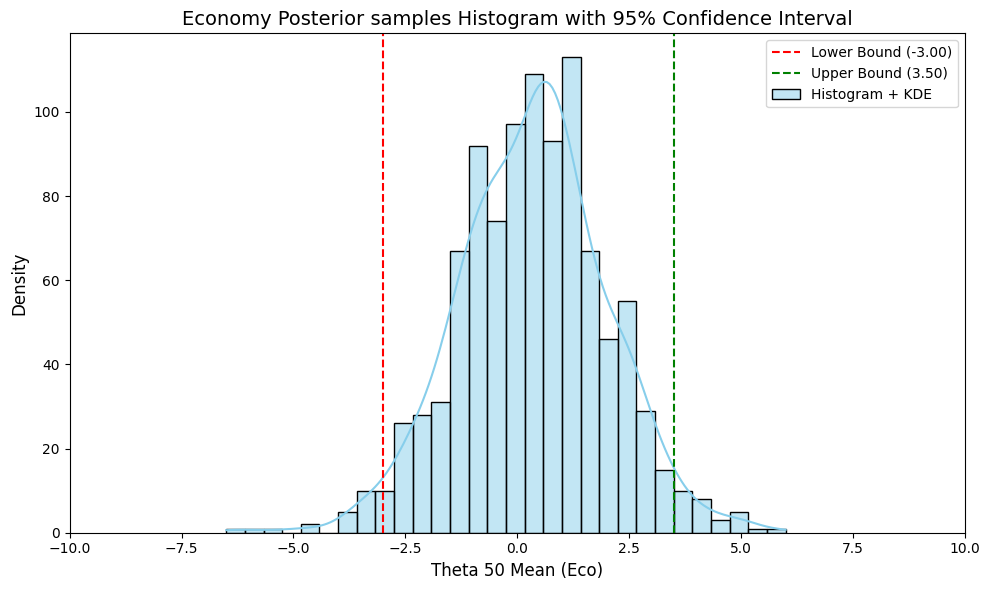

In [563]:
# 히스토그램 및 KDE 플롯
plt.figure(figsize=(10, 6))
sns.histplot(theta_50_mean_eco, kde=True, color='skyblue', bins=30, label='Histogram + KDE')

# 신뢰구간 표시 (점선)
plt.axvline(eco_lb, color='red', linestyle='--', label=f'Lower Bound ({eco_lb:.2f})')
plt.axvline(eco_ub, color='green', linestyle='--', label=f'Upper Bound ({eco_ub:.2f})')

# 그래프 꾸미기
plt.title('Economy Posterior samples Histogram with 95% Confidence Interval', fontsize=14)
plt.xlim(-10, 10)
plt.xlabel('Theta 50 Mean (Eco)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()

# 그래프 출력
plt.show()

In [564]:
wth_lb = np.percentile(theta_50_mean_wth, 2.5)  # 하위 2.5%
wth_ub = np.percentile(theta_50_mean_wth, 97.5)  # 상위 97.5%

In [565]:
print("eco: (", eco_lb, ", ", eco_ub, ")")
print("wth: (", wth_lb, ", ", wth_ub, ")")

eco: ( -3.0 ,  3.5 )
wth: ( -2.5 ,  2.4458333333333324 )


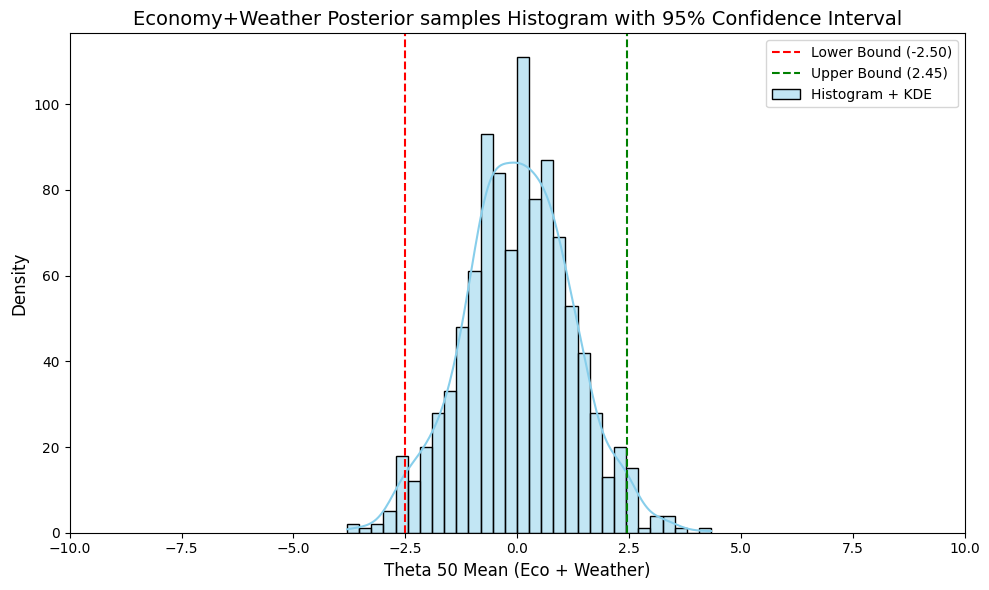

In [566]:
# 히스토그램 및 KDE 플롯
plt.figure(figsize=(10, 6))
sns.histplot(theta_50_mean_wth, kde=True, color='skyblue', bins=30, label='Histogram + KDE')

# 신뢰구간 표시 (점선)
plt.axvline(wth_lb, color='red', linestyle='--', label=f'Lower Bound ({wth_lb:.2f})')
plt.axvline(wth_ub, color='green', linestyle='--', label=f'Upper Bound ({wth_ub:.2f})')

# 그래프 꾸미기
plt.title('Economy+Weather Posterior samples Histogram with 95% Confidence Interval', fontsize=14)
plt.xlim(-10, 10)
plt.xlabel('Theta 50 Mean (Eco + Weather)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()

# 그래프 출력
plt.show()

In [567]:
print(eco_lb, eco_ub)
print(wth_lb, wth_ub)

-3.0 3.5
-2.5 2.4458333333333324


## HPDI

In [568]:
import arviz as az

# HPDI 계산 (95% 신용구간)
hpdi_eco = az.hdi(accepted_samples_d0, hdi_prob=0.95)
print(f"95% 신용구간 (HPDI): {hpdi_eco}")

95% 신용구간 (HPDI): [-6  7]


In [569]:
np.std(accepted_samples_d0)

3.5472431652540988

In [570]:
hpdi_wth = az.hdi(accepted_samples_d1, hdi_prob=0.95)
print(f"95% 신용구간 (HPDI): {hpdi_wth}")

95% 신용구간 (HPDI): [-6  6]


In [571]:
np.std(accepted_samples_d1)

3.435924810587668

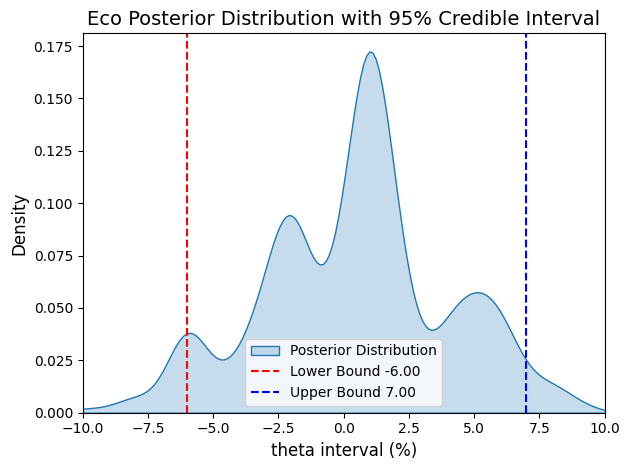

In [572]:
# 사후 확률 분포 KDE 플롯
sns.kdeplot(accepted_samples_d0, fill=True, label="Posterior Distribution")

# 신용구간 시각화
plt.axvline(-6, color='red', linestyle='--', label=f"Lower Bound {hpdi_eco[0]:.2f}")
plt.axvline(7, color='blue', linestyle='--', label=f"Upper Bound {hpdi_eco[1]:.2f}")
plt.title("Eco Posterior Distribution with 95% Credible Interval", fontsize=14)

# 그래프 꾸미기
plt.xlim(-10, 10)
plt.xlabel('theta interval (%)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

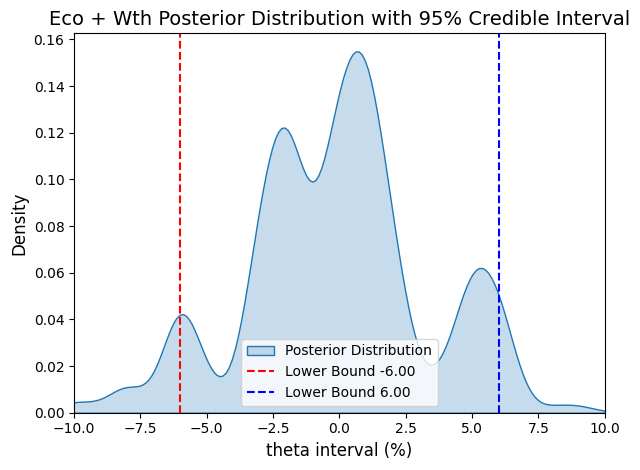

In [414]:
# 사후 확률 분포 KDE 플롯
sns.kdeplot(accepted_samples_d1, fill=True, label="Posterior Distribution")

plt.axvline(-6, color='red', linestyle='--', label=f"Lower Bound {hpdi_wth[0]:.2f}")
plt.axvline(6, color='blue', linestyle='--', label=f"Lower Bound {hpdi_wth[1]:.2f}")
plt.title("Eco + Wth Posterior Distribution with 95% Credible Interval", fontsize=14)

# 그래프 꾸미기
plt.xlim(-10, 10)
plt.xlabel('theta interval (%)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()